# ECBM E4040 Project: Multi-digit Number Recognition from Street View Imagery using Deep Convolution Neural Networks

This notebook implements the following tasks:

(1) Read image data from processed pickle file and perform data preprocessing

(2) Build full model and define the functions for prediction and accuracy evaluation

(3) Initaite tensorflow session to train the model with train set and perform cross validation

(4) Load the trained model and perform tesing using test set

In [1]:
#Load necessary library
import numpy as np
from scipy import misc
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import time


## Load SVHN data

We preprocessed the image from the original SVHN datasets and saved as pickle files. This way, the file size is reduced so that we can upload to GCP and also save the time needed to read the data.

In [2]:
# Read data from pickle file
# Pickle files need to stored at the current working directory in order for this code to find the file and read it
import six.moves.cPickle as pickle
import sys
import gzip

data_dir=os.getcwd()
output_file = 'trainpkl.gz'
out_path = os.path.join(data_dir, output_file)
f_test = gzip.open(out_path, 'rb')
test_set = pickle.load(f_test)
f_test.close()


In [3]:
# Validate that we have captured all data. The full data set should have dimension (33401, 8748)
# There are 33401 images and the dimension is 54*54*3 = 8748
print(test_set['images'].shape)

(33401, 8748)


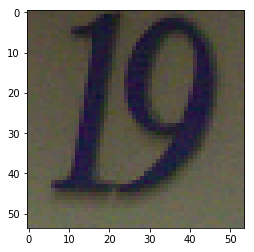

In [4]:
# Show one image from the set
plt.imshow(test_set["images"][0].reshape(54,54,3))

In [5]:
#Create labels and length list to store the digit sequence of each street number image and the length of the street number
label=[] 
length=[]
for i in range(len(test_set["labels"])):
    label.append([int(x) for x in test_set["labels"][i]])
    length.append(len(label[-1]))

## Process image data and Transform labels into proper format for training


### (1) Transform street number sequence label and length label

Because the street numbers have multiple digits and variable length, we need to perform one-hot encoding to transform the different street number into a uniform format. 

For digits in the street number, we encode the digit information in a 6 * 11 matrix. The row is the position of each digit in the street number. The column represent the digits (from 0 to 9 and the last column indicate there is not digit in that position). For example, the street number '19' will have the following matrix:

[0 1 0 0 0 0 0 0 0 0 0  
 0 0 0 0 0 0 0 0 1 0 0  
 0 0 0 0 0 0 0 0 0 0 1  
 0 0 0 0 0 0 0 0 0 0 1  
 0 0 0 0 0 0 0 0 0 0 1  
 0 0 0 0 0 0 0 0 0 0 1]  
 
 Similarly, for the length of each street number, we use one hot encoding.The length vector has 7 columns, represent length = 0 to 5 and the last column indicating more than 5. so the number '19' has length 2 and the corresponding length label vector is: [0 0 1 0 0 0 0 0].

In [6]:
#Convert the digits sequence to one hot encoding format
#The dimension of thats_hot vector is (n, 6, 11). 

Train_no = 33401 # total number of training samples
thats_hot=np.zeros((Train_no,6,11), dtype=int)
for i in range(Train_no):
    for j in range(len(label[i])):
        thats_hot[i][j][label[i][j]]=1
        for j in range(len(label[i]),6):
            thats_hot[i][j][10]=1

In [7]:
#One hot encoding of length vector
#The dimension of hot_length vector is (n, 7). 
hot_length = np.zeros((len(length), 7),dtype=int)
hot_length[np.arange(len(length),), length] = 1

### (2) Split data into training set and validation set and preprocess image

To improve accuracy, we need to substract the mean image from the feature vector. In addition, we split the training data into 20% as validation set and 80% as training.

In [8]:
#Split into train and validation set

#number of data to be used in actual training, can be changed to use small sets for hyperparemeter tuning
n=33401

#Split validation and train by 20%-80%
n_train = int(n*0.8)
Pic_crop_Final = test_set["images"]

# Substract mean image from the data and reshape
x_train = np.array(Pic_crop_Final[:n_train])
x_val = np.array(Pic_crop_Final[n_train:n])
mean_image = np.mean(x_train, axis=0)
x_train = x_train.astype(np.float32) - mean_image.astype(np.float32)
x_val = x_val.astype(np.float32) - mean_image

x_train = x_train.reshape([-1,54,54,3])
x_val = x_val.reshape([-1,54,54,3])

#Get training labels, training labels need to be in one-hot encoding format
label_train_hot= thats_hot[:n_train]
length_train_hot = hot_length[:n_train]

#Get the validation labels
#The labels used in validation and testing need to be in is original format: eg. label = [1,9], length = [2]
label_val=label[n_train:n]
length_val = length[n_train:n]



In [9]:
#Validate the dimension of training and validation set

print('Training data shape: ',x_train.shape)
print('Validation data shape: ',x_val.shape)
print('Training digits label shape: ',label_train_hot.shape)
print('Training length label shape: ',length_train_hot.shape)
# First training sample is '19'
print('Show the digits label of the first training sample:\n',label_train_hot[0])
print('Show the length label of the first training sample: ',length_train_hot[0])
print('Show the digits of the first valdation sample: ',label_val[0])
print('Show the length of the first valdation sample: ',length_val[0])


Training data shape:  (26720, 54, 54, 3)
Validation data shape:  (6681, 54, 54, 3)
Training digits label shape:  (26720, 6, 11)
Training length label shape:  (26720, 7)
Show the digits label of the first training sample:
 [[0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]]
Show the length label of the first training sample:  [0 0 1 0 0 0 0]
Show the digits of the first valdation sample:  [2]
Show the length of the first valdation sample:  1


## Define model and other function

### (1) Model structure

The model proposed by the paper have eight convolution layers, followed by two fully connected layers. This network will take the input image and transform it in to a feature vector H. Then the H vector will be the input for 6 classifiers which do independent prediction on the length, and digits. 

In [10]:
def model (x, length_labels, digits_labels, is_training=True, drop_rate=0.5):
# Input:  x: image feature, dimension  = (n * 54 * 54 * 3) 
#         length_labels: one-hot encoded of street number length, dimension = (n * 7)
#         digits_labels: one-hot encoded of street number digits, dimension = (n * 6 * 11)
#         is_training: indicate if model is in training or testing
#         drop_rate: dropout rate during training
# Output:  
#         length: dimension = (n * 7), represent the "probability" for different length
#         digits_prob: dimension = (n * 6 * 11), represent the "probability" of each digit at each position
#         loss: total cross-entropy loss of all 6 classifiers

    # Only apply dropout in training stage
    if is_training == False:
        drop_rate=0

    #CNN structure, the input image size is 54*54*3 and the filter size for each layer is [48, 64, 128, 160, 192, 192, 192, 192]
    #CNN filter size [5,5] with zero padding, and batch normalization is applied for each layer
    #max pooling is performed with stride alternating between 2 and 1, such that half of the layers reduce output the size by half
    with tf.variable_scope('CNN1'):
        conv1 = tf.layers.conv2d(x, filters=48, kernel_size=[5, 5], padding='same')
        norm1 = tf.layers.batch_normalization(conv1)
        activation1 = tf.nn.relu(norm1)
        pool1 = tf.layers.max_pooling2d(activation1, pool_size=[2, 2], strides=2, padding='same')
        layer1 = pool1
        # Output size is 27 * 27 * 48
        

    with tf.variable_scope('CNN2'):
        conv2 = tf.layers.conv2d(layer1, filters=64, kernel_size=[5, 5], padding='same')
        norm2 = tf.layers.batch_normalization(conv2)
        activation2 = tf.nn.relu(norm2)
        pool2 = tf.layers.max_pooling2d(activation2, pool_size=[2, 2], strides=1, padding='same')
        layer2 = pool2  
        #Output size is 27 * 27 * 64
        

    with tf.variable_scope('CNN3'):
        conv3 = tf.layers.conv2d(layer2, filters=128, kernel_size=[5, 5], padding='same')
        norm3 = tf.layers.batch_normalization(conv3)
        activation3 = tf.nn.relu(norm3)
        pool3 = tf.layers.max_pooling2d(activation3, pool_size=[2, 2], strides=2, padding='same')
        layer3 = pool3  
        #Output size is 14 * 14 * 128
        

    with tf.variable_scope('CNN4'):
        conv4 = tf.layers.conv2d(layer3, filters=160, kernel_size=[5, 5], padding='same')
        norm4 = tf.layers.batch_normalization(conv4)
        activation4 = tf.nn.relu(norm4)
        pool4 = tf.layers.max_pooling2d(activation4, pool_size=[2, 2], strides=1, padding='same')
        layer4 = pool4  
        # Output size is 14 * 14 *160
        

    with tf.variable_scope('CNN5'):
        conv5 = tf.layers.conv2d(layer4, filters=192, kernel_size=[5, 5], padding='same')
        norm5 = tf.layers.batch_normalization(conv5)
        activation5 = tf.nn.relu(norm5)
        pool5 = tf.layers.max_pooling2d(activation5, pool_size=[2, 2], strides=2, padding='same')
        layer5 = pool5  
        #Output size is 7 * 7 * 192
        

    with tf.variable_scope('CNN6'):
        conv6 = tf.layers.conv2d(layer5, filters=192, kernel_size=[5, 5], padding='same')
        norm6 = tf.layers.batch_normalization(conv6)
        activation6 = tf.nn.relu(norm6)
        pool6 = tf.layers.max_pooling2d(activation6, pool_size=[2, 2], strides=1, padding='same')
        layer6 = pool6  
        #Output size is 7 * 7 * 192
        

    with tf.variable_scope('CNN7'):
        conv7 = tf.layers.conv2d(layer6, filters=192, kernel_size=[5, 5], padding='same')
        norm7 = tf.layers.batch_normalization(conv7)
        activation7 = tf.nn.relu(norm7)
        pool7 = tf.layers.max_pooling2d(activation7, pool_size=[2, 2], strides=2, padding='same')
        layer7 = pool7  
        #Output size is 4 * 4 * 192
        

    with tf.variable_scope('CNN8'):
        conv8 = tf.layers.conv2d(layer7, filters=192, kernel_size=[5, 5], padding='same')
        norm8 = tf.layers.batch_normalization(conv8)
        activation8 = tf.nn.relu(norm8)
        pool8 = tf.layers.max_pooling2d(activation8, pool_size=[2, 2], strides=1, padding='same')
        layer8 = pool8  
        #Output 4 * 4 * 192

    input_to_fc = tf.reshape(layer8, [-1, 4 * 4 * 192])
    
    # feed the CNN output to two fully connected layer, units size [3072, 3072]
    # drop out is applied only in fully connected layers
    with tf.variable_scope('fc1'):
        fc1 = tf.layers.dense(input_to_fc, units=3072, activation=tf.nn.relu)
        dropout1 = tf.layers.dropout(fc1, rate=drop_rate)
        layer9 = dropout1

    with tf.variable_scope('fc2'):
        fc2 = tf.layers.dense(layer9, units=3072, activation=tf.nn.relu)
        dropout2 = tf.layers.dropout(fc2, rate=drop_rate)
        h = dropout2

    #The output of the fully connected layer is the H feature vector mentioned in the paper.
    #It is then fed into 6 different classifiers to predict length, and individual digit at each position.
    #The paper assumes the maximum length of the street number is 5 so we only have 5 classifers for digits
    
    with tf.variable_scope('digit1'):
        digit1 = tf.layers.dense(h, units=11)

    with tf.variable_scope('digit2'):
        digit2 = tf.layers.dense(h, units=11)

    with tf.variable_scope('digit3'):
        digit3 = tf.layers.dense(h, units=11)

    with tf.variable_scope('digit4'):
        digit4 = tf.layers.dense(h, units=11)

    with tf.variable_scope('digit5'):
        digit5 = tf.layers.dense(h, units=11)

    with tf.variable_scope('length'):
        length = tf.layers.dense(h, units=7)
    
    # Combine the probability prediction of each digit
    digits_prob = tf.stack([digit1, digit2, digit3, digit4, digit5], axis=1)

    # Calculate the cross entropy loss
    with tf.name_scope("loss"):
        length_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=length_labels, logits=length))
        digit1_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 0], logits=digits_prob[:, 0, :]))
        digit2_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 1], logits=digits_prob[:, 1, :]))
        digit3_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 2], logits=digits_prob[:, 2, :]))
        digit4_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 3], logits=digits_prob[:, 3, :]))
        digit5_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 4], logits=digits_prob[:, 4, :]))
        total_loss = length_loss + digit1_loss + digit2_loss + digit3_loss + digit4_loss + digit5_loss
    
    return length, digits_prob, total_loss

### (2) Function to predict the length and digits at each position

The model above return two vectors: length (n,7) and digit_prob at each position (n,5,11). These vectors will be transformed into probailities using softmax. The prediction function will then predict the length based on the overall probability:
![overall probability](./prob.PNG)

Instead of calculating the product of all probabilities, we calculate the sum of the log to avoid diminishing probability issue. It also return the digit prediction at each position by choosing the number that have the highest probability at each position.

In [11]:
def predict (length_logits, digits_logits):
# Input:  length_logits: dimension(n * 7), to be converted probabilities with softmax function
#         digits_logits: dimension (n * 5 * 11), to be converted to probabilities with softmax function
# Output: length_prediction: dimension(n * 1), predicted length for each sample
#         digits_prediction: size (n * 5 ), predicted digits at each position

    with tf.name_scope('predict'):
        # Convert the input to probability using softmax and take log
        p_l =tf.log(tf.nn.softmax(length_logits,axis=1))
        p_d1=tf.log(tf.nn.softmax(digits_logits[:, 0, :],axis=1))
        p_d2=tf.log(tf.nn.softmax(digits_logits[:, 1, :],axis=1))
        p_d3=tf.log(tf.nn.softmax(digits_logits[:, 2, :],axis=1))
        p_d4=tf.log(tf.nn.softmax(digits_logits[:, 3, :],axis=1))
        p_d5=tf.log(tf.nn.softmax(digits_logits[:, 4, :],axis=1))
        
        # Calculate overall log_P(S) of the sequence for different length (L = 0, 1, 2, 3, 4, 5, >5)
        # by summing up the probability of the length and probabilites of each digit
        ps0 = tf.add_n([p_l[:,0]])
        ps1= tf.add_n([p_l[:,1],tf.reduce_max(p_d1,axis = 1)])
        ps2= tf.add_n([p_l[:,2],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1)])
        ps3= tf.add_n([p_l[:,3],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1)])
        ps4= tf.add_n([p_l[:,4],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1),tf.reduce_max(p_d4,axis = 1)])
        ps5= tf.add_n([p_l[:,5],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1),tf.reduce_max(p_d4,axis = 1),tf.reduce_max(p_d5,axis = 1)])
        ps6= tf.add_n([p_l[:,6],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1),tf.reduce_max(p_d4,axis = 1),tf.reduce_max(p_d5,axis = 1)])
        
        #The predicted length is the one with the highest overall log_P(S)
        ps = tf.stack([ps0,ps1, ps2, ps3, ps4, ps5,ps6], axis=1)
        length_predictions =tf.argmax(ps,axis=1)
        
        #Pick the most possible digit at each position
        d1 = tf.argmax(p_d1, axis=1)
        d2 = tf.argmax(p_d2, axis=1)
        d3 = tf.argmax(p_d3, axis=1)
        d4 = tf.argmax(p_d4, axis=1)
        d5 = tf.argmax(p_d5, axis=1)
        digits_prediction = tf.stack([d1, d2, d3, d4, d5], axis=1)

    return length_predictions,digits_prediction

### (3) Function to compare the predicted street number and calculate accuracy


In [12]:
def evaluate (length_predictions, digits_predictions, length_label, label):

# Input:  length_label: list of length for each street number, dimension = (n,1)
#         label: list of individual digits of each street number
#         length_predictions: numpy array of predicted length for each sample
#         digits_predictions: numpy array of predicted 5 digits for each sample
# Output: 
#         output_list: list of predicted street number
#         accuracy: prediction accuracy

    output_list = []
    num_error = 0
    for i in range(len(length_label)):
        str_pred = np.ndarray.tolist(digits_predictions[i,:length_predictions[i]])
        output_list.append(str_pred)
        if str_pred != label[i]:
            num_error+=1
    accuracy = (1-num_error/len(length_label))*100
    return output_list, accuracy

## Training and Hyper-parameter tuning

In this session, we create the training sessions to train the model. However, due to the long computation time, we first test out different combinations of hyper parameters using a subset of 3000 samples and we select the one with best performance.

We performed a grid search (a total of 27 combinations) over the following selections of the hyper parameters:

- Drop out rate : 0.2, 0.5, 0.8

- Learning rate: 1e-4, 1e-3, 1e-2

- Batch size: 16, 32, 64

The set of parameters that gives the best accuracy is batch size = 16, drop out rate = 0.8, learning rate = 1e-4. We then use this setting to train using the full dataset for 100 epochs. Users can skip this part since we tried many possible combinations of hyper parameters and the re-run the training sessions takes very long time. The best model is provided and users can directly use it to see test performance.

### (1) Grid search on optimal hyper parameters using 3000 data

In [23]:
# Pick a subset of full data to be used in hyper parameter tuning

#number of data to be used in hyperparemeter tuning
n_tune=3000

#Split validation and train by 20%-80%
n_tune_train = int(n_tune*0.8)

# Substract mean image from the data and reshape
x_tune_train = np.array(Pic_crop_Final[:n_tune_train])
x_tune_val = np.array(Pic_crop_Final[n_tune_train:n_tune])
mean_image_tune = np.mean(x_tune_train, axis=0)
x_tune_train = x_tune_train.astype(np.float32) - mean_image_tune.astype(np.float32)
x_tune_val = x_tune_val.astype(np.float32) - mean_image_tune

x_tune_train = x_tune_train.reshape([-1,54,54,3])
x_tune_val = x_tune_val.reshape([-1,54,54,3])

#Get training labels, training labels need to be in one-hot encoding format
label_tune_train_hot= thats_hot[:n_tune_train]
length_tune_train_hot = hot_length[:n_tune_train]

#Get the validation labels
#The labels used in validation and testing need to be in is original format: eg. label = [1,9], length = [2]
label_tune_val=label[n_tune_train:n_tune]
length_tune_val = length[n_tune_train:n_tune]


In [24]:
print('Training data shape: ',x_tune_train.shape)
print('Validation data shape: ',x_tune_val.shape)
print('Training digits label shape: ',label_tune_train_hot.shape)
print('Training length label shape: ',length_tune_train_hot.shape)
# First training sample is '19'
print('Show the digits label of the first training sample:\n',label_tune_train_hot[0])
print('Show the length label of the first training sample: ',length_tune_train_hot[0])
print('Show the digits of the first valdation sample: ',label_tune_val[0])
print('Show the length of the first valdation sample: ',length_tune_val[0])

Training data shape:  (2400, 54, 54, 3)
Validation data shape:  (600, 54, 54, 3)
Training digits label shape:  (2400, 6, 11)
Training length label shape:  (2400, 7)
Show the digits label of the first training sample:
 [[0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]]
Show the length label of the first training sample:  [0 0 1 0 0 0 0]
Show the digits of the first valdation sample:  [1, 0]
Show the length of the first valdation sample:  2


In [26]:
#Initiate training Session for different combination of hyper parameters
# first sets of parameter combinations for batch size = 16
param = [[16, 1e-4, 0.2],[16, 1e-4, 0.5],[16, 1e-3, 0.5],[16, 1e-2, 0.2], [16, 1e-2, 0.5]]
for p in range(len(param)):
    tf.reset_default_graph()
    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, shape=(None,54,54,3))
        length_labels = tf.placeholder(tf.int64, shape=(None,None,))
        digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
        is_training = tf.placeholder(tf.bool, name='is_training')

    num_train = x_tune_train.shape[0]
    batch_size = param[p][0]
    epoches = 100
    num_batch = num_train//batch_size
    learning_rate = param[p][1]
    drop_rate = param[p][2]
    length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    length_predictions, digits_predictions = predict(length_logits, digits_logits)

    iter_total = 0
    best_acc = 0
    cur_model_name = 'SVHN_{}'.format(int(time.time()))
    pre_trained_model = ''

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        saver = tf.train.Saver()
        if pre_trained_model != '':
            saver.restore(sess, pre_trained_model)
        tic = time.time()
        for e in range(epoches):
            print("epoch {} ".format(e + 1))
            for i in range(num_batch):
                iter_total += 1
                choice=np.random.choice(num_train, size=batch_size, replace=False)
                batch_x, batch_digits, batch_length = x_tune_train[choice], label_tune_train_hot[choice], length_tune_train_hot[choice]
                _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                          feed_dict={x:batch_x , 
                                                                                     length_labels:batch_length,
                                                                                     digits_labels:batch_digits,
                                                                                     is_training: True})


                if iter_total % 50 == 0:

                # do validation
                    length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_tune_val, is_training: False})
                    pred_str, valid_acc = evaluate(length_tf, digit_tf, length_tune_val, label_tune_val)
                    print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))

                    # when achieve the best validation accuracy, we store the model paramters
                    if valid_acc > best_acc:
                        best_acc = valid_acc
                        print('Best validation accuracy: {}%'.format(best_acc))

                        #saver.save(sess, 'model/{}'.format(cur_model_name))
    print("Training ends for param {}. The best valid accuracy is {}. Model named {}.".format(p,best_acc, cur_model_name))
    toc = time.time()
    duration = toc-tic
    if duration > 60:
        duration_m = int(duration / 60)
        duration_s = duration-duration_m*60
        print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
    else:
        print("Total time is {} seconds.".format(duration))


epoch 1 
50 batch training loss: 6.5499396324157715 validation accuracy : 1.6666666666666718%
Best validation accuracy: 1.6666666666666718%
100 batch training loss: 6.424825668334961 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.949575424194336 validation accuracy : 1.6666666666666718%
epoch 2 
50 batch training loss: 6.642295837402344 validation accuracy : 2.6666666666666616%
Best validation accuracy: 2.6666666666666616%
100 batch training loss: 5.532802581787109 validation accuracy : 3.166666666666662%
Best validation accuracy: 3.166666666666662%
150 batch training loss: 5.7879958152771 validation accuracy : 5.333333333333334%
Best validation accuracy: 5.333333333333334%
epoch 3 
50 batch training loss: 5.739106178283691 validation accuracy : 4.333333333333334%
100 batch training loss: 4.0238566398620605 validation accuracy : 6.499999999999995%
Best validation accuracy: 6.499999999999995%
150 batch training loss: 4.0165629386901855 validation accuracy : 9.99999

100 batch training loss: 0.13941776752471924 validation accuracy : 50.33333333333334%
150 batch training loss: 0.005743511952459812 validation accuracy : 53.16666666666667%
Best validation accuracy: 53.16666666666667%
epoch 29 
50 batch training loss: 0.23143725097179413 validation accuracy : 53.333333333333336%
Best validation accuracy: 53.333333333333336%
100 batch training loss: 0.12429642677307129 validation accuracy : 49.16666666666667%
150 batch training loss: 0.15489286184310913 validation accuracy : 50.0%
epoch 30 
50 batch training loss: 0.4642501771450043 validation accuracy : 47.5%
100 batch training loss: 0.03520389646291733 validation accuracy : 50.16666666666667%
150 batch training loss: 0.04125477001070976 validation accuracy : 50.5%
epoch 31 
50 batch training loss: 0.2071588933467865 validation accuracy : 49.83333333333333%
100 batch training loss: 0.017446493729948997 validation accuracy : 51.83333333333333%
150 batch training loss: 0.0014523400459438562 validation ac

50 batch training loss: 0.0016446373192593455 validation accuracy : 52.16666666666667%
100 batch training loss: 0.577144205570221 validation accuracy : 48.66666666666667%
150 batch training loss: 0.22512929141521454 validation accuracy : 51.5%
epoch 61 
50 batch training loss: 0.07555560767650604 validation accuracy : 49.5%
100 batch training loss: 0.3452177047729492 validation accuracy : 50.33333333333334%
150 batch training loss: 0.04686993360519409 validation accuracy : 53.0%
epoch 62 
50 batch training loss: 0.002630822826176882 validation accuracy : 51.0%
100 batch training loss: 0.11733295023441315 validation accuracy : 52.16666666666667%
150 batch training loss: 0.0005123845767229795 validation accuracy : 52.16666666666667%
epoch 63 
50 batch training loss: 0.05966302007436752 validation accuracy : 53.333333333333336%
100 batch training loss: 0.0058162398636341095 validation accuracy : 53.16666666666667%
150 batch training loss: 0.10814602673053741 validation accuracy : 54.66666

100 batch training loss: 0.0007644664729014039 validation accuracy : 50.83333333333333%
150 batch training loss: 0.02264697663486004 validation accuracy : 49.33333333333333%
epoch 92 
50 batch training loss: 0.003141741268336773 validation accuracy : 50.83333333333333%
100 batch training loss: 0.05781581252813339 validation accuracy : 52.666666666666664%
150 batch training loss: 0.012242026627063751 validation accuracy : 51.5%
epoch 93 
50 batch training loss: 0.04117480665445328 validation accuracy : 52.0%
100 batch training loss: 0.8500918745994568 validation accuracy : 51.5%
150 batch training loss: 0.0003040873270947486 validation accuracy : 52.33333333333333%
epoch 94 
50 batch training loss: 0.008297467604279518 validation accuracy : 51.66666666666666%
100 batch training loss: 0.00031240444513969123 validation accuracy : 52.666666666666664%
150 batch training loss: 0.005835711024701595 validation accuracy : 53.333333333333336%
epoch 95 
50 batch training loss: 0.00010553118045208

150 batch training loss: 0.10571742802858353 validation accuracy : 48.83333333333333%
epoch 19 
50 batch training loss: 0.1692538857460022 validation accuracy : 45.333333333333336%
100 batch training loss: 0.6315264105796814 validation accuracy : 45.333333333333336%
150 batch training loss: 0.09505245089530945 validation accuracy : 50.16666666666667%
epoch 20 
50 batch training loss: 0.13800503313541412 validation accuracy : 47.16666666666667%
100 batch training loss: 0.22329311072826385 validation accuracy : 47.5%
150 batch training loss: 0.39852723479270935 validation accuracy : 47.66666666666667%
epoch 21 
50 batch training loss: 0.4395580291748047 validation accuracy : 47.16666666666667%
100 batch training loss: 0.0674079954624176 validation accuracy : 46.833333333333336%
150 batch training loss: 0.4002857506275177 validation accuracy : 45.833333333333336%
epoch 22 
50 batch training loss: 0.29863885045051575 validation accuracy : 48.83333333333333%
100 batch training loss: 0.03649

50 batch training loss: 0.10122232139110565 validation accuracy : 52.0%
100 batch training loss: 0.020141160115599632 validation accuracy : 51.33333333333333%
150 batch training loss: 0.06010991334915161 validation accuracy : 49.16666666666667%
epoch 51 
50 batch training loss: 0.2765237092971802 validation accuracy : 47.333333333333336%
100 batch training loss: 0.0882544293999672 validation accuracy : 48.0%
150 batch training loss: 0.05622386187314987 validation accuracy : 46.0%
epoch 52 
50 batch training loss: 0.018266310915350914 validation accuracy : 50.83333333333333%
100 batch training loss: 0.005160948261618614 validation accuracy : 52.16666666666667%
150 batch training loss: 0.02336970344185829 validation accuracy : 51.0%
epoch 53 
50 batch training loss: 0.048337146639823914 validation accuracy : 48.5%
100 batch training loss: 0.1280350536108017 validation accuracy : 52.0%
150 batch training loss: 0.016954628750681877 validation accuracy : 46.166666666666664%
epoch 54 
50 bat

150 batch training loss: 0.008574798703193665 validation accuracy : 50.83333333333333%
epoch 82 
50 batch training loss: 0.03802008554339409 validation accuracy : 52.16666666666667%
100 batch training loss: 0.015329677611589432 validation accuracy : 52.0%
150 batch training loss: 0.03515266999602318 validation accuracy : 51.33333333333333%
epoch 83 
50 batch training loss: 0.008616921491920948 validation accuracy : 51.83333333333333%
100 batch training loss: 0.0003028798964805901 validation accuracy : 52.0%
150 batch training loss: 0.0006189604755491018 validation accuracy : 52.0%
epoch 84 
50 batch training loss: 0.00630258210003376 validation accuracy : 51.66666666666666%
100 batch training loss: 0.8199874758720398 validation accuracy : 51.66666666666666%
150 batch training loss: 0.0010699349222704768 validation accuracy : 50.66666666666666%
epoch 85 
50 batch training loss: 0.0031957419123500586 validation accuracy : 50.66666666666666%
100 batch training loss: 0.0005027368315495551 

150 batch training loss: 7.486856937408447 validation accuracy : 1.6666666666666718%
epoch 13 
50 batch training loss: 6.887628078460693 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.438808441162109 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.60947847366333 validation accuracy : 1.6666666666666718%
epoch 14 
50 batch training loss: 7.6592698097229 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.825847625732422 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.420337200164795 validation accuracy : 1.6666666666666718%
epoch 15 
50 batch training loss: 6.872352123260498 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.499239921569824 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.890622138977051 validation accuracy : 1.6666666666666718%
epoch 16 
50 batch training loss: 6.650751113891602 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.01568

50 batch training loss: 7.440732955932617 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.992530345916748 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.6456379890441895 validation accuracy : 1.6666666666666718%
epoch 45 
50 batch training loss: 6.967555999755859 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.665798664093018 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.189447402954102 validation accuracy : 1.6666666666666718%
epoch 46 
50 batch training loss: 6.584399700164795 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.104293346405029 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.252655982971191 validation accuracy : 1.6666666666666718%
epoch 47 
50 batch training loss: 6.775731086730957 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.736502647399902 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.39440298080

100 batch training loss: 7.362191200256348 validation accuracy : 1.6666666666666718%
150 batch training loss: 5.922076225280762 validation accuracy : 1.6666666666666718%
epoch 76 
50 batch training loss: 6.7956671714782715 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.131364345550537 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.153290271759033 validation accuracy : 1.6666666666666718%
epoch 77 
50 batch training loss: 6.555211544036865 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.885822296142578 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.984614849090576 validation accuracy : 1.6666666666666718%
epoch 78 
50 batch training loss: 6.110720634460449 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.122581958770752 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.4656548500061035 validation accuracy : 1.6666666666666718%
epoch 79 
50 batch training loss: 7.

150 batch training loss: 6.879330635070801 validation accuracy : 1.6666666666666718%
epoch 6 
50 batch training loss: 6.616554260253906 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.766897201538086 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.932577133178711 validation accuracy : 1.6666666666666718%
epoch 7 
50 batch training loss: 7.3703083992004395 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.085257053375244 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.053617477416992 validation accuracy : 1.6666666666666718%
epoch 8 
50 batch training loss: 7.440883636474609 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.5493950843811035 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.102719306945801 validation accuracy : 1.6666666666666718%
epoch 9 
50 batch training loss: 7.154721736907959 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.9934

50 batch training loss: 6.644424915313721 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.580641269683838 validation accuracy : 1.6666666666666718%
150 batch training loss: 8.48333740234375 validation accuracy : 1.6666666666666718%
epoch 38 
50 batch training loss: 6.430026054382324 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.779996395111084 validation accuracy : 1.6666666666666718%
150 batch training loss: 8.0366792678833 validation accuracy : 1.6666666666666718%
epoch 39 
50 batch training loss: 7.8753581047058105 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.126511096954346 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.665927886962891 validation accuracy : 1.6666666666666718%
epoch 40 
50 batch training loss: 7.923146724700928 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.143296718597412 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.58418178558349

100 batch training loss: 7.051573753356934 validation accuracy : 1.6666666666666718%
150 batch training loss: 8.087629318237305 validation accuracy : 1.6666666666666718%
epoch 69 
50 batch training loss: 6.735334873199463 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.8068976402282715 validation accuracy : 1.6666666666666718%
150 batch training loss: 8.27517318725586 validation accuracy : 1.6666666666666718%
epoch 70 
50 batch training loss: 5.592496395111084 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.158790588378906 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.0105743408203125 validation accuracy : 1.6666666666666718%
epoch 71 
50 batch training loss: 7.783315658569336 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.089787006378174 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.45471715927124 validation accuracy : 1.6666666666666718%
epoch 72 
50 batch training loss: 7.28

150 batch training loss: 7.351537227630615 validation accuracy : 1.6666666666666718%
epoch 100 
50 batch training loss: 7.621918678283691 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.596792697906494 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.672119617462158 validation accuracy : 1.6666666666666718%
Training ends for param 3. The best valid accuracy is 1.6666666666666718. Model named SVHN_1544892347.
Total time is 15 minutes, 35.899010181427 seconds.
epoch 1 
50 batch training loss: 6.330113410949707 validation accuracy : 1.6666666666666718%
Best validation accuracy: 1.6666666666666718%
100 batch training loss: 7.405670166015625 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.6240973472595215 validation accuracy : 1.6666666666666718%
epoch 2 
50 batch training loss: 6.075151443481445 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.7103095054626465 validation accuracy : 1.3333333333333308%
150 bat

50 batch training loss: 6.703808784484863 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.369013786315918 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.652126312255859 validation accuracy : 1.6666666666666718%
epoch 31 
50 batch training loss: 7.073403358459473 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.843969345092773 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.560993671417236 validation accuracy : 1.6666666666666718%
epoch 32 
50 batch training loss: 6.045839786529541 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.613495349884033 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.389825820922852 validation accuracy : 1.6666666666666718%
epoch 33 
50 batch training loss: 7.866078853607178 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.839230060577393 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.153826236724

100 batch training loss: 6.98155403137207 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.516526699066162 validation accuracy : 1.6666666666666718%
epoch 62 
50 batch training loss: 6.0967326164245605 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.023148059844971 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.125410079956055 validation accuracy : 1.6666666666666718%
epoch 63 
50 batch training loss: 6.447375774383545 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.568894386291504 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.789098739624023 validation accuracy : 1.6666666666666718%
epoch 64 
50 batch training loss: 6.181150913238525 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.603452682495117 validation accuracy : 1.6666666666666718%
150 batch training loss: 8.206413269042969 validation accuracy : 1.6666666666666718%
epoch 65 
50 batch training loss: 7.65

150 batch training loss: 7.416609287261963 validation accuracy : 1.6666666666666718%
epoch 93 
50 batch training loss: 6.60193395614624 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.964598655700684 validation accuracy : 1.6666666666666718%
150 batch training loss: 8.398529052734375 validation accuracy : 1.6666666666666718%
epoch 94 
50 batch training loss: 7.10885763168335 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.410520553588867 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.611171245574951 validation accuracy : 1.6666666666666718%
epoch 95 
50 batch training loss: 7.521358489990234 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.978688716888428 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.363725662231445 validation accuracy : 1.6666666666666718%
epoch 96 
50 batch training loss: 6.663023948669434 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.9097

In [30]:
#Initiate training Session for different combination of hyper parameters
# Second sets of parameter combination for batch size = 16
param = [[16, 1e-4, 0.8],[16, 1e-3, 0.2],[16, 1e-3, 0.8], [16, 1e-2, 0.8]]
for p in range(len(param)):
    tf.reset_default_graph()
    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, shape=(None,54,54,3))
        length_labels = tf.placeholder(tf.int64, shape=(None,None,))
        digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
        is_training = tf.placeholder(tf.bool, name='is_training')

    num_train = x_tune_train.shape[0]
    batch_size = param[p][0]
    epoches = 100
    num_batch = num_train//batch_size
    learning_rate = param[p][1]
    drop_rate = param[p][2]
    length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    length_predictions, digits_predictions = predict(length_logits, digits_logits)

    iter_total = 0
    best_acc = 0
    cur_model_name = 'SVHN_{}'.format(int(time.time()))
    pre_trained_model = ''

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        saver = tf.train.Saver()
        if pre_trained_model != '':
            saver.restore(sess, pre_trained_model)
        tic = time.time()
        for e in range(epoches):
            print("epoch {} ".format(e + 1))
            for i in range(num_batch):
                iter_total += 1
                choice=np.random.choice(num_train, size=batch_size, replace=False)
                batch_x, batch_digits, batch_length = x_tune_train[choice], label_tune_train_hot[choice], length_tune_train_hot[choice]
                _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                          feed_dict={x:batch_x , 
                                                                                     length_labels:batch_length,
                                                                                     digits_labels:batch_digits,
                                                                                     is_training: True})


                if iter_total % 50 == 0:

                # do validation
                    length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_tune_val, is_training: False})
                    pred_str, valid_acc = evaluate(length_tf, digit_tf, length_tune_val, label_tune_val)
                    print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))

                    # when achieve the best validation accuracy, we store the model paramters
                    if valid_acc > best_acc:
                        best_acc = valid_acc
                        print('Best validation accuracy: {}%'.format(best_acc))

                        #saver.save(sess, 'model/{}'.format(cur_model_name))
    print("Training ends for param {}. The best valid accuracy is {}. Model named {}.".format(p,best_acc, cur_model_name))
    toc = time.time()
    duration = toc-tic
    if duration > 60:
        duration_m = int(duration / 60)
        duration_s = duration-duration_m*60
        print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
    else:
        print("Total time is {} seconds.".format(duration))


epoch 1 
50 batch training loss: 7.194722652435303 validation accuracy : 1.8333333333333313%
Best validation accuracy: 1.8333333333333313%
100 batch training loss: 7.620519638061523 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.507958889007568 validation accuracy : 3.3333333333333326%
Best validation accuracy: 3.3333333333333326%
epoch 2 
50 batch training loss: 6.892385959625244 validation accuracy : 1.8333333333333313%
100 batch training loss: 5.6215691566467285 validation accuracy : 3.0000000000000027%
150 batch training loss: 7.198150157928467 validation accuracy : 3.6666666666666625%
Best validation accuracy: 3.6666666666666625%
epoch 3 
50 batch training loss: 5.9393744468688965 validation accuracy : 4.833333333333334%
Best validation accuracy: 4.833333333333334%
100 batch training loss: 4.264486312866211 validation accuracy : 6.999999999999995%
Best validation accuracy: 6.999999999999995%
150 batch training loss: 5.127333164215088 validation accuracy : 9.6

50 batch training loss: 0.005848592147231102 validation accuracy : 50.66666666666666%
100 batch training loss: 0.0569453090429306 validation accuracy : 53.666666666666664%
150 batch training loss: 0.019471144303679466 validation accuracy : 52.666666666666664%
epoch 30 
50 batch training loss: 0.16068485379219055 validation accuracy : 52.666666666666664%
100 batch training loss: 0.07695098221302032 validation accuracy : 50.83333333333333%
150 batch training loss: 0.15336570143699646 validation accuracy : 50.5%
epoch 31 
50 batch training loss: 0.20031732320785522 validation accuracy : 50.66666666666666%
100 batch training loss: 0.025415830314159393 validation accuracy : 51.0%
150 batch training loss: 0.020449969917535782 validation accuracy : 53.0%
epoch 32 
50 batch training loss: 0.06725305318832397 validation accuracy : 49.0%
100 batch training loss: 0.31022122502326965 validation accuracy : 52.0%
150 batch training loss: 0.3937680721282959 validation accuracy : 49.66666666666667%
ep

150 batch training loss: 0.05021455138921738 validation accuracy : 49.33333333333333%
epoch 61 
50 batch training loss: 0.04519768804311752 validation accuracy : 52.666666666666664%
100 batch training loss: 0.003568985965102911 validation accuracy : 53.49999999999999%
150 batch training loss: 0.002299718791618943 validation accuracy : 52.666666666666664%
epoch 62 
50 batch training loss: 0.005729922093451023 validation accuracy : 53.833333333333336%
100 batch training loss: 0.19368740916252136 validation accuracy : 53.333333333333336%
150 batch training loss: 0.638203501701355 validation accuracy : 49.66666666666667%
epoch 63 
50 batch training loss: 0.03619769588112831 validation accuracy : 50.16666666666667%
100 batch training loss: 0.022320112213492393 validation accuracy : 51.66666666666666%
150 batch training loss: 0.17844286561012268 validation accuracy : 50.33333333333334%
epoch 64 
50 batch training loss: 0.1605202704668045 validation accuracy : 52.16666666666667%
100 batch tra

100 batch training loss: 1.0348655450798105e-05 validation accuracy : 56.49999999999999%
150 batch training loss: 1.214442590935505e-06 validation accuracy : 56.333333333333336%
epoch 91 
50 batch training loss: 2.980229965032777e-07 validation accuracy : 56.333333333333336%
100 batch training loss: 3.1217484774970217e-06 validation accuracy : 56.333333333333336%
150 batch training loss: 1.221892716785078e-06 validation accuracy : 56.49999999999999%
epoch 92 
50 batch training loss: 5.513415999303106e-07 validation accuracy : 56.49999999999999%
100 batch training loss: 1.0803278200910427e-06 validation accuracy : 56.49999999999999%
150 batch training loss: 6.556492735398933e-07 validation accuracy : 56.49999999999999%
epoch 93 
50 batch training loss: 1.6391264523463178e-07 validation accuracy : 56.49999999999999%
100 batch training loss: 4.947111847286578e-06 validation accuracy : 56.666666666666664%
150 batch training loss: 7.599579703310155e-07 validation accuracy : 56.6666666666666

100 batch training loss: 5.624637126922607 validation accuracy : 10.166666666666668%
150 batch training loss: 3.8612453937530518 validation accuracy : 12.0%
Best validation accuracy: 12.0%
epoch 19 
50 batch training loss: 3.6873316764831543 validation accuracy : 10.999999999999998%
100 batch training loss: 4.471572399139404 validation accuracy : 11.833333333333329%
150 batch training loss: 4.7769694328308105 validation accuracy : 13.0%
Best validation accuracy: 13.0%
epoch 20 
50 batch training loss: 3.7976553440093994 validation accuracy : 12.666666666666671%
100 batch training loss: 5.467559337615967 validation accuracy : 11.5%
150 batch training loss: 3.8792507648468018 validation accuracy : 10.999999999999998%
epoch 21 
50 batch training loss: 4.485028266906738 validation accuracy : 13.666666666666671%
Best validation accuracy: 13.666666666666671%
100 batch training loss: 5.114552974700928 validation accuracy : 13.666666666666671%
150 batch training loss: 4.052196502685547 validat

100 batch training loss: 1.4068964719772339 validation accuracy : 35.83333333333333%
150 batch training loss: 0.3250158429145813 validation accuracy : 37.33333333333333%
epoch 47 
50 batch training loss: 0.5874306559562683 validation accuracy : 37.66666666666667%
Best validation accuracy: 37.66666666666667%
100 batch training loss: 1.6068835258483887 validation accuracy : 37.33333333333333%
150 batch training loss: 0.9423754811286926 validation accuracy : 36.16666666666667%
epoch 48 
50 batch training loss: 0.45251643657684326 validation accuracy : 37.83333333333333%
Best validation accuracy: 37.83333333333333%
100 batch training loss: 0.8575139045715332 validation accuracy : 38.66666666666667%
Best validation accuracy: 38.66666666666667%
150 batch training loss: 1.0967894792556763 validation accuracy : 38.33333333333333%
epoch 49 
50 batch training loss: 2.9662370681762695 validation accuracy : 35.83333333333333%
100 batch training loss: 0.8379669189453125 validation accuracy : 35.5%


150 batch training loss: 0.14202669262886047 validation accuracy : 42.00000000000001%
epoch 77 
50 batch training loss: 0.25354182720184326 validation accuracy : 41.0%
100 batch training loss: 0.5039328336715698 validation accuracy : 40.666666666666664%
150 batch training loss: 0.10916957259178162 validation accuracy : 42.833333333333336%
epoch 78 
50 batch training loss: 0.5314103960990906 validation accuracy : 42.166666666666664%
100 batch training loss: 0.0030465242452919483 validation accuracy : 42.166666666666664%
150 batch training loss: 2.1504690647125244 validation accuracy : 40.5%
epoch 79 
50 batch training loss: 0.2416328489780426 validation accuracy : 39.16666666666667%
100 batch training loss: 0.23260493576526642 validation accuracy : 36.83333333333333%
150 batch training loss: 0.28218650817871094 validation accuracy : 40.166666666666664%
epoch 80 
50 batch training loss: 0.15497371554374695 validation accuracy : 41.0%
100 batch training loss: 0.8586775064468384 validation

50 batch training loss: 5.559833526611328 validation accuracy : 3.166666666666662%
100 batch training loss: 6.152012348175049 validation accuracy : 2.6666666666666616%
150 batch training loss: 6.585004806518555 validation accuracy : 2.833333333333332%
epoch 8 
50 batch training loss: 7.641773223876953 validation accuracy : 3.166666666666662%
100 batch training loss: 6.4359660148620605 validation accuracy : 2.3333333333333317%
150 batch training loss: 5.647183895111084 validation accuracy : 3.3333333333333326%
Best validation accuracy: 3.3333333333333326%
epoch 9 
50 batch training loss: 6.5472331047058105 validation accuracy : 2.833333333333332%
100 batch training loss: 6.773703575134277 validation accuracy : 3.6666666666666625%
Best validation accuracy: 3.6666666666666625%
150 batch training loss: 5.661617279052734 validation accuracy : 2.0000000000000018%
epoch 10 
50 batch training loss: 5.678471088409424 validation accuracy : 3.3333333333333326%
100 batch training loss: 4.745293617

150 batch training loss: 2.5242044925689697 validation accuracy : 34.66666666666667%
epoch 35 
50 batch training loss: 1.5809922218322754 validation accuracy : 35.333333333333336%
100 batch training loss: 1.3643907308578491 validation accuracy : 34.5%
150 batch training loss: 0.9538482427597046 validation accuracy : 38.66666666666667%
Best validation accuracy: 38.66666666666667%
epoch 36 
50 batch training loss: 1.757673978805542 validation accuracy : 36.0%
100 batch training loss: 1.0655181407928467 validation accuracy : 36.66666666666667%
150 batch training loss: 1.1091679334640503 validation accuracy : 37.16666666666667%
epoch 37 
50 batch training loss: 1.3062937259674072 validation accuracy : 34.66666666666667%
100 batch training loss: 1.0915098190307617 validation accuracy : 35.5%
150 batch training loss: 1.0732691287994385 validation accuracy : 38.0%
epoch 38 
50 batch training loss: 1.3743658065795898 validation accuracy : 36.83333333333333%
100 batch training loss: 1.520670413

50 batch training loss: 1.1200590133666992 validation accuracy : 37.33333333333333%
100 batch training loss: 0.3560221791267395 validation accuracy : 37.83333333333333%
150 batch training loss: 0.19952411949634552 validation accuracy : 38.83333333333333%
epoch 68 
50 batch training loss: 0.5156967639923096 validation accuracy : 41.5%
100 batch training loss: 0.08061762899160385 validation accuracy : 40.5%
150 batch training loss: 0.11655735224485397 validation accuracy : 40.166666666666664%
epoch 69 
50 batch training loss: 0.8951568603515625 validation accuracy : 38.16666666666667%
100 batch training loss: 0.5200393795967102 validation accuracy : 37.83333333333333%
150 batch training loss: 2.802659511566162 validation accuracy : 31.499999999999993%
epoch 70 
50 batch training loss: 0.8717452883720398 validation accuracy : 35.83333333333333%
100 batch training loss: 0.30547142028808594 validation accuracy : 37.5%
150 batch training loss: 0.53775554895401 validation accuracy : 38.833333

100 batch training loss: 0.09245676547288895 validation accuracy : 42.666666666666664%
150 batch training loss: 0.17462049424648285 validation accuracy : 42.166666666666664%
epoch 100 
50 batch training loss: 0.037930481135845184 validation accuracy : 41.5%
100 batch training loss: 0.016852373257279396 validation accuracy : 40.666666666666664%
150 batch training loss: 0.021018939092755318 validation accuracy : 42.166666666666664%
Training ends for param 2. The best valid accuracy is 43.50000000000001. Model named SVHN_1544910853.
Total time is 15 minutes, 40.49455404281616 seconds.
epoch 1 
50 batch training loss: 7.785080432891846 validation accuracy : 1.6666666666666718%
Best validation accuracy: 1.6666666666666718%
100 batch training loss: 7.051519870758057 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.210203170776367 validation accuracy : 1.3333333333333308%
epoch 2 
50 batch training loss: 7.366413116455078 validation accuracy : 1.6666666666666718%
100 batch

150 batch training loss: 7.742269992828369 validation accuracy : 1.6666666666666718%
epoch 30 
50 batch training loss: 6.827534198760986 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.387970924377441 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.240653038024902 validation accuracy : 1.6666666666666718%
epoch 31 
50 batch training loss: 7.696370601654053 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.471659183502197 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.634376525878906 validation accuracy : 1.6666666666666718%
epoch 32 
50 batch training loss: 6.596903324127197 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.535475730895996 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.248518466949463 validation accuracy : 1.6666666666666718%
epoch 33 
50 batch training loss: 7.765042304992676 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.80

50 batch training loss: 7.258368015289307 validation accuracy : 1.6666666666666718%
100 batch training loss: 8.29000186920166 validation accuracy : 1.6666666666666718%
150 batch training loss: 5.432709217071533 validation accuracy : 1.6666666666666718%
epoch 62 
50 batch training loss: 8.202646255493164 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.844733715057373 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.782064914703369 validation accuracy : 1.6666666666666718%
epoch 63 
50 batch training loss: 7.836876392364502 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.267827033996582 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.66789436340332 validation accuracy : 1.6666666666666718%
epoch 64 
50 batch training loss: 7.190181732177734 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.400927543640137 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.58304119110107

100 batch training loss: 6.529943943023682 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.894089221954346 validation accuracy : 1.6666666666666718%
epoch 93 
50 batch training loss: 6.717639923095703 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.107025623321533 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.593748569488525 validation accuracy : 1.6666666666666718%
epoch 94 
50 batch training loss: 7.356202602386475 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.888896465301514 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.300548076629639 validation accuracy : 1.6666666666666718%
epoch 95 
50 batch training loss: 6.681572914123535 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.91638708114624 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.03765869140625 validation accuracy : 1.6666666666666718%
epoch 96 
50 batch training loss: 6.3903

In [27]:
#Initiate training Session for different combination of hyper parameters
# First sets of Combination for batch size = 32
param = [[32, 1e-4, 0.2],[32, 1e-4, 0.5],[32, 1e-3, 0.2],[32, 1e-3, 0.5],[32, 1e-2, 0.2], [32, 1e-2, 0.5]]
for p in range(len(param)):
    tf.reset_default_graph()
    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, shape=(None,54,54,3))
        length_labels = tf.placeholder(tf.int64, shape=(None,None,))
        digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
        is_training = tf.placeholder(tf.bool, name='is_training')

    num_train = x_tune_train.shape[0]
    batch_size = param[p][0]
    epoches = 100
    num_batch = num_train//batch_size
    learning_rate = param[p][1]
    drop_rate = param[p][2]
    length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    length_predictions, digits_predictions = predict(length_logits, digits_logits)

    iter_total = 0
    best_acc = 0
    cur_model_name = 'SVHN_{}'.format(int(time.time()))
    pre_trained_model = ''

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        saver = tf.train.Saver()
        if pre_trained_model != '':
            saver.restore(sess, pre_trained_model)
        tic = time.time()
        for e in range(epoches):
            print("epoch {} ".format(e + 1))
            for i in range(num_batch):
                iter_total += 1
                choice=np.random.choice(num_train, size=batch_size, replace=False)
                batch_x, batch_digits, batch_length = x_tune_train[choice], label_tune_train_hot[choice], length_tune_train_hot[choice]
                _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                          feed_dict={x:batch_x , 
                                                                                     length_labels:batch_length,
                                                                                     digits_labels:batch_digits,
                                                                                     is_training: True})


                if iter_total % 50 == 0:

                # do validation
                    length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_tune_val, is_training: False})
                    pred_str, valid_acc = evaluate(length_tf, digit_tf, length_tune_val, label_tune_val)
                    print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))

                    # when achieve the best validation accuracy, we store the model paramters
                    if valid_acc > best_acc:
                        best_acc = valid_acc
                        print('Best validation accuracy: {}%'.format(best_acc))

                        #saver.save(sess, 'model/{}'.format(cur_model_name))
    print("Training ends for param {}. The best valid accuracy is {}. Model named {}.".format(p,best_acc, cur_model_name))
    toc = time.time()
    duration = toc-tic
    if duration > 60:
        duration_m = int(duration / 60)
        duration_s = duration-duration_m*60
        print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
    else:
        print("Total time is {} seconds.".format(duration))


epoch 1 
50 batch training loss: 6.903583526611328 validation accuracy : 1.6666666666666718%
Best validation accuracy: 1.6666666666666718%
epoch 2 
25 batch training loss: 6.209985733032227 validation accuracy : 2.3333333333333317%
Best validation accuracy: 2.3333333333333317%
75 batch training loss: 6.107086181640625 validation accuracy : 3.500000000000003%
Best validation accuracy: 3.500000000000003%
epoch 3 
50 batch training loss: 6.461740493774414 validation accuracy : 4.833333333333334%
Best validation accuracy: 4.833333333333334%
epoch 4 
25 batch training loss: 5.241674423217773 validation accuracy : 8.999999999999996%
Best validation accuracy: 8.999999999999996%
75 batch training loss: 4.483577728271484 validation accuracy : 11.16666666666667%
Best validation accuracy: 11.16666666666667%
epoch 5 
50 batch training loss: 5.11915397644043 validation accuracy : 17.333333333333336%
Best validation accuracy: 17.333333333333336%
epoch 6 
25 batch training loss: 4.055732250213623 val

75 batch training loss: 0.08199311792850494 validation accuracy : 40.5%
epoch 55 
50 batch training loss: 0.012104585766792297 validation accuracy : 46.666666666666664%
epoch 56 
25 batch training loss: 0.2445954829454422 validation accuracy : 44.833333333333336%
75 batch training loss: 0.01350201666355133 validation accuracy : 48.83333333333333%
epoch 57 
50 batch training loss: 0.02313559129834175 validation accuracy : 46.333333333333336%
epoch 58 
25 batch training loss: 0.06673499941825867 validation accuracy : 45.833333333333336%
75 batch training loss: 0.19502262771129608 validation accuracy : 46.166666666666664%
epoch 59 
50 batch training loss: 0.03799832984805107 validation accuracy : 47.5%
epoch 60 
25 batch training loss: 0.08487224578857422 validation accuracy : 45.666666666666664%
75 batch training loss: 0.06167604774236679 validation accuracy : 48.33333333333333%
epoch 61 
50 batch training loss: 0.4879617989063263 validation accuracy : 43.50000000000001%
epoch 62 
25 bat

75 batch training loss: 0.9824612140655518 validation accuracy : 37.16666666666667%
Best validation accuracy: 37.16666666666667%
epoch 11 
50 batch training loss: 0.747564435005188 validation accuracy : 37.5%
Best validation accuracy: 37.5%
epoch 12 
25 batch training loss: 1.1441110372543335 validation accuracy : 39.83333333333333%
Best validation accuracy: 39.83333333333333%
75 batch training loss: 2.1966781616210938 validation accuracy : 40.833333333333336%
Best validation accuracy: 40.833333333333336%
epoch 13 
50 batch training loss: 0.8468911647796631 validation accuracy : 39.666666666666664%
epoch 14 
25 batch training loss: 0.40229859948158264 validation accuracy : 42.00000000000001%
Best validation accuracy: 42.00000000000001%
75 batch training loss: 0.29230985045433044 validation accuracy : 42.666666666666664%
Best validation accuracy: 42.666666666666664%
epoch 15 
50 batch training loss: 0.5577149391174316 validation accuracy : 44.99999999999999%
Best validation accuracy: 44

75 batch training loss: 0.0031599944923073053 validation accuracy : 50.33333333333334%
epoch 69 
50 batch training loss: 0.23855441808700562 validation accuracy : 51.33333333333333%
epoch 70 
25 batch training loss: 0.016587603837251663 validation accuracy : 51.83333333333333%
75 batch training loss: 0.04199850186705589 validation accuracy : 54.0%
Best validation accuracy: 54.0%
epoch 71 
50 batch training loss: 0.0008492444176226854 validation accuracy : 52.83333333333333%
epoch 72 
25 batch training loss: 0.017475919798016548 validation accuracy : 50.83333333333333%
75 batch training loss: 0.001716054743155837 validation accuracy : 49.5%
epoch 73 
50 batch training loss: 0.025971785187721252 validation accuracy : 48.33333333333333%
epoch 74 
25 batch training loss: 0.056936729699373245 validation accuracy : 49.33333333333333%
75 batch training loss: 0.024546455591917038 validation accuracy : 48.0%
epoch 75 
50 batch training loss: 0.1590898036956787 validation accuracy : 48.5%
epoch 

75 batch training loss: 6.751260280609131 validation accuracy : 1.6666666666666718%
epoch 29 
50 batch training loss: 6.933882713317871 validation accuracy : 1.6666666666666718%
epoch 30 
25 batch training loss: 7.016546249389648 validation accuracy : 1.6666666666666718%
75 batch training loss: 5.996078014373779 validation accuracy : 1.6666666666666718%
epoch 31 
50 batch training loss: 6.210043907165527 validation accuracy : 1.6666666666666718%
epoch 32 
25 batch training loss: 6.525078296661377 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.819704055786133 validation accuracy : 1.6666666666666718%
epoch 33 
50 batch training loss: 7.567794322967529 validation accuracy : 1.6666666666666718%
epoch 34 
25 batch training loss: 6.539953231811523 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.357581615447998 validation accuracy : 1.6666666666666718%
epoch 35 
50 batch training loss: 6.681516170501709 validation accuracy : 1.6666666666666718%
epoch 

50 batch training loss: 7.681625843048096 validation accuracy : 1.6666666666666718%
epoch 90 
25 batch training loss: 6.896938800811768 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.878612995147705 validation accuracy : 1.6666666666666718%
epoch 91 
50 batch training loss: 7.287327289581299 validation accuracy : 1.6666666666666718%
epoch 92 
25 batch training loss: 6.938456058502197 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.760307312011719 validation accuracy : 1.6666666666666718%
epoch 93 
50 batch training loss: 6.996927261352539 validation accuracy : 1.6666666666666718%
epoch 94 
25 batch training loss: 8.184886932373047 validation accuracy : 1.6666666666666718%
75 batch training loss: 8.208210945129395 validation accuracy : 1.6666666666666718%
epoch 95 
50 batch training loss: 6.802192211151123 validation accuracy : 1.6666666666666718%
epoch 96 
25 batch training loss: 7.387306213378906 validation accuracy : 1.6666666666666718%
75 bat

75 batch training loss: 7.149010181427002 validation accuracy : 1.6666666666666718%
epoch 49 
50 batch training loss: 6.989500045776367 validation accuracy : 1.6666666666666718%
epoch 50 
25 batch training loss: 7.4600300788879395 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.847037315368652 validation accuracy : 1.6666666666666718%
epoch 51 
50 batch training loss: 7.096301078796387 validation accuracy : 1.6666666666666718%
epoch 52 
25 batch training loss: 7.086333274841309 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.082149982452393 validation accuracy : 1.6666666666666718%
epoch 53 
50 batch training loss: 6.992548942565918 validation accuracy : 1.6666666666666718%
epoch 54 
25 batch training loss: 6.850255012512207 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.853400230407715 validation accuracy : 1.6666666666666718%
epoch 55 
50 batch training loss: 7.005307674407959 validation accuracy : 1.6666666666666718%
epoch

epoch 8 
25 batch training loss: 6.633059501647949 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.927827835083008 validation accuracy : 1.6666666666666718%
epoch 9 
50 batch training loss: 7.56089448928833 validation accuracy : 1.6666666666666718%
epoch 10 
25 batch training loss: 6.146398067474365 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.76878023147583 validation accuracy : 1.6666666666666718%
epoch 11 
50 batch training loss: 6.480186462402344 validation accuracy : 1.6666666666666718%
epoch 12 
25 batch training loss: 7.655586242675781 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.658749103546143 validation accuracy : 1.6666666666666718%
epoch 13 
50 batch training loss: 7.161437034606934 validation accuracy : 1.6666666666666718%
epoch 14 
25 batch training loss: 6.934942722320557 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.150010108947754 validation accuracy : 1.6666666666666718%
epoch 15 


75 batch training loss: 6.952593803405762 validation accuracy : 1.6666666666666718%
epoch 69 
50 batch training loss: 6.670948505401611 validation accuracy : 1.6666666666666718%
epoch 70 
25 batch training loss: 6.749922752380371 validation accuracy : 1.6666666666666718%
75 batch training loss: 8.012727737426758 validation accuracy : 1.6666666666666718%
epoch 71 
50 batch training loss: 6.826480388641357 validation accuracy : 1.6666666666666718%
epoch 72 
25 batch training loss: 6.931356430053711 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.617299556732178 validation accuracy : 1.6666666666666718%
epoch 73 
50 batch training loss: 7.341362953186035 validation accuracy : 1.6666666666666718%
epoch 74 
25 batch training loss: 6.720334529876709 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.381877899169922 validation accuracy : 1.6666666666666718%
epoch 75 
50 batch training loss: 7.63592529296875 validation accuracy : 1.6666666666666718%
epoch 7

epoch 28 
25 batch training loss: 6.831879138946533 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.19146203994751 validation accuracy : 1.6666666666666718%
epoch 29 
50 batch training loss: 7.495548725128174 validation accuracy : 1.6666666666666718%
epoch 30 
25 batch training loss: 6.973905086517334 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.069156169891357 validation accuracy : 1.6666666666666718%
epoch 31 
50 batch training loss: 7.482820987701416 validation accuracy : 1.6666666666666718%
epoch 32 
25 batch training loss: 7.1164398193359375 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.720727443695068 validation accuracy : 1.6666666666666718%
epoch 33 
50 batch training loss: 7.340358734130859 validation accuracy : 1.6666666666666718%
epoch 34 
25 batch training loss: 6.7606425285339355 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.604869365692139 validation accuracy : 1.6666666666666718%
epoch

75 batch training loss: 7.559345722198486 validation accuracy : 1.6666666666666718%
epoch 89 
50 batch training loss: 7.502506256103516 validation accuracy : 1.6666666666666718%
epoch 90 
25 batch training loss: 7.065486431121826 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.034535884857178 validation accuracy : 1.6666666666666718%
epoch 91 
50 batch training loss: 7.6468825340271 validation accuracy : 1.6666666666666718%
epoch 92 
25 batch training loss: 7.336066246032715 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.045909404754639 validation accuracy : 1.6666666666666718%
epoch 93 
50 batch training loss: 6.557960510253906 validation accuracy : 1.6666666666666718%
epoch 94 
25 batch training loss: 6.875725269317627 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.257687568664551 validation accuracy : 1.6666666666666718%
epoch 95 
50 batch training loss: 6.71668815612793 validation accuracy : 1.6666666666666718%
epoch 96 

In [31]:
#Initiate training Session for different combination of hyper parameters
# Second sets of Combination for batch size = 32
param = [[32, 1e-4, 0.8],[32, 1e-3, 0.8],[32, 1e-2, 0.8]]
for p in range(len(param)):
    tf.reset_default_graph()
    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, shape=(None,54,54,3))
        length_labels = tf.placeholder(tf.int64, shape=(None,None,))
        digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
        is_training = tf.placeholder(tf.bool, name='is_training')

    num_train = x_tune_train.shape[0]
    batch_size = param[p][0]
    epoches = 100
    num_batch = num_train//batch_size
    learning_rate = param[p][1]
    drop_rate = param[p][2]
    length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    length_predictions, digits_predictions = predict(length_logits, digits_logits)

    iter_total = 0
    best_acc = 0
    cur_model_name = 'SVHN_{}'.format(int(time.time()))
    pre_trained_model = ''

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        saver = tf.train.Saver()
        if pre_trained_model != '':
            saver.restore(sess, pre_trained_model)
        tic = time.time()
        for e in range(epoches):
            print("epoch {} ".format(e + 1))
            for i in range(num_batch):
                iter_total += 1
                choice=np.random.choice(num_train, size=batch_size, replace=False)
                batch_x, batch_digits, batch_length = x_tune_train[choice], label_tune_train_hot[choice], length_tune_train_hot[choice]
                _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                          feed_dict={x:batch_x , 
                                                                                     length_labels:batch_length,
                                                                                     digits_labels:batch_digits,
                                                                                     is_training: True})


                if iter_total % 50 == 0:

                # do validation
                    length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_tune_val, is_training: False})
                    pred_str, valid_acc = evaluate(length_tf, digit_tf, length_tune_val, label_tune_val)
                    print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))

                    # when achieve the best validation accuracy, we store the model paramters
                    if valid_acc > best_acc:
                        best_acc = valid_acc
                        print('Best validation accuracy: {}%'.format(best_acc))

                        #saver.save(sess, 'model/{}'.format(cur_model_name))
    print("Training ends for param {}. The best valid accuracy is {}. Model named {}.".format(p,best_acc, cur_model_name))
    toc = time.time()
    duration = toc-tic
    if duration > 60:
        duration_m = int(duration / 60)
        duration_s = duration-duration_m*60
        print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
    else:
        print("Total time is {} seconds.".format(duration))


epoch 1 
50 batch training loss: 6.732703685760498 validation accuracy : 1.6666666666666718%
Best validation accuracy: 1.6666666666666718%
epoch 2 
25 batch training loss: 6.879054546356201 validation accuracy : 2.0000000000000018%
Best validation accuracy: 2.0000000000000018%
75 batch training loss: 6.488073825836182 validation accuracy : 3.3333333333333326%
Best validation accuracy: 3.3333333333333326%
epoch 3 
50 batch training loss: 5.927674293518066 validation accuracy : 7.333333333333336%
Best validation accuracy: 7.333333333333336%
epoch 4 
25 batch training loss: 4.750662803649902 validation accuracy : 12.333333333333329%
Best validation accuracy: 12.333333333333329%
75 batch training loss: 4.3869547843933105 validation accuracy : 14.000000000000002%
Best validation accuracy: 14.000000000000002%
epoch 5 
50 batch training loss: 4.275780200958252 validation accuracy : 19.833333333333336%
Best validation accuracy: 19.833333333333336%
epoch 6 
25 batch training loss: 3.40652728080

epoch 56 
25 batch training loss: 0.01266482938081026 validation accuracy : 48.0%
75 batch training loss: 0.019500460475683212 validation accuracy : 43.333333333333336%
epoch 57 
50 batch training loss: 0.36954042315483093 validation accuracy : 47.16666666666667%
epoch 58 
25 batch training loss: 0.007075732108205557 validation accuracy : 47.0%
75 batch training loss: 0.00019333671662025154 validation accuracy : 48.5%
epoch 59 
50 batch training loss: 0.0006252466700971127 validation accuracy : 48.83333333333333%
epoch 60 
25 batch training loss: 0.006340299267321825 validation accuracy : 47.0%
75 batch training loss: 0.3758839964866638 validation accuracy : 42.166666666666664%
epoch 61 
50 batch training loss: 0.2879948019981384 validation accuracy : 46.5%
epoch 62 
25 batch training loss: 0.02008802443742752 validation accuracy : 49.16666666666667%
75 batch training loss: 0.01809518411755562 validation accuracy : 48.83333333333333%
epoch 63 
50 batch training loss: 0.0639387443661689

50 batch training loss: 5.043789386749268 validation accuracy : 8.499999999999996%
Best validation accuracy: 8.499999999999996%
epoch 12 
25 batch training loss: 4.478382110595703 validation accuracy : 9.999999999999998%
Best validation accuracy: 9.999999999999998%
75 batch training loss: 4.547865867614746 validation accuracy : 8.999999999999996%
epoch 13 
50 batch training loss: 4.207651615142822 validation accuracy : 12.83333333333333%
Best validation accuracy: 12.83333333333333%
epoch 14 
25 batch training loss: 3.365159034729004 validation accuracy : 15.500000000000004%
Best validation accuracy: 15.500000000000004%
75 batch training loss: 3.7485225200653076 validation accuracy : 17.166666666666664%
Best validation accuracy: 17.166666666666664%
epoch 15 
50 batch training loss: 3.7292776107788086 validation accuracy : 18.333333333333336%
Best validation accuracy: 18.333333333333336%
epoch 16 
25 batch training loss: 4.457793235778809 validation accuracy : 17.166666666666664%
75 batc

75 batch training loss: 0.13680876791477203 validation accuracy : 42.166666666666664%
epoch 67 
50 batch training loss: 0.1950242668390274 validation accuracy : 41.166666666666664%
epoch 68 
25 batch training loss: 0.4338562488555908 validation accuracy : 42.00000000000001%
75 batch training loss: 0.17225944995880127 validation accuracy : 41.5%
epoch 69 
50 batch training loss: 0.27895596623420715 validation accuracy : 43.166666666666664%
epoch 70 
25 batch training loss: 0.061444345861673355 validation accuracy : 42.333333333333336%
75 batch training loss: 1.062767505645752 validation accuracy : 40.0%
epoch 71 
50 batch training loss: 0.3129676282405853 validation accuracy : 41.5%
epoch 72 
25 batch training loss: 0.13738514482975006 validation accuracy : 40.166666666666664%
75 batch training loss: 0.4574951231479645 validation accuracy : 41.666666666666664%
epoch 73 
50 batch training loss: 0.3270857632160187 validation accuracy : 44.333333333333336%
epoch 74 
25 batch training loss:

epoch 26 
25 batch training loss: 6.613128662109375 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.230440139770508 validation accuracy : 1.6666666666666718%
epoch 27 
50 batch training loss: 8.136448860168457 validation accuracy : 1.6666666666666718%
epoch 28 
25 batch training loss: 6.358210563659668 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.549233913421631 validation accuracy : 1.3333333333333308%
epoch 29 
50 batch training loss: 7.2835564613342285 validation accuracy : 1.6666666666666718%
epoch 30 
25 batch training loss: 7.248283863067627 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.787034034729004 validation accuracy : 1.6666666666666718%
epoch 31 
50 batch training loss: 7.402894020080566 validation accuracy : 1.6666666666666718%
epoch 32 
25 batch training loss: 8.002179145812988 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.601120948791504 validation accuracy : 1.6666666666666718%
epoch

75 batch training loss: 6.513779163360596 validation accuracy : 1.6666666666666718%
epoch 87 
50 batch training loss: 6.395210266113281 validation accuracy : 1.6666666666666718%
epoch 88 
25 batch training loss: 7.610659122467041 validation accuracy : 1.6666666666666718%
75 batch training loss: 7.372203350067139 validation accuracy : 1.6666666666666718%
epoch 89 
50 batch training loss: 7.849997043609619 validation accuracy : 1.6666666666666718%
epoch 90 
25 batch training loss: 6.9705610275268555 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.388206481933594 validation accuracy : 1.6666666666666718%
epoch 91 
50 batch training loss: 6.966557502746582 validation accuracy : 1.6666666666666718%
epoch 92 
25 batch training loss: 7.151368618011475 validation accuracy : 1.6666666666666718%
75 batch training loss: 6.920174598693848 validation accuracy : 1.6666666666666718%
epoch 93 
50 batch training loss: 6.861041069030762 validation accuracy : 1.6666666666666718%
epoch

In [29]:
#Initiate training Session for different combination of hyper parameters
# Combination for batch size = 64
param = [[64, 1e-4, 0.2],[64, 1e-4, 0.5],[64, 1e-4, 0.8],[64, 1e-3, 0.2],[64, 1e-3, 0.5],[64, 1e-3, 0.8],
         [64, 1e-2, 0.2], [64, 1e-2, 0.5], [64, 1e-2, 0.8]]
for p in range(len(param)):
    tf.reset_default_graph()
    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, shape=(None,54,54,3))
        length_labels = tf.placeholder(tf.int64, shape=(None,None,))
        digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
        is_training = tf.placeholder(tf.bool, name='is_training')

    num_train = x_tune_train.shape[0]
    batch_size = param[p][0]
    epoches = 100
    num_batch = num_train//batch_size
    learning_rate = param[p][1]
    drop_rate = param[p][2]
    length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    length_predictions, digits_predictions = predict(length_logits, digits_logits)

    iter_total = 0
    best_acc = 0
    cur_model_name = 'SVHN_{}'.format(int(time.time()))
    pre_trained_model = ''

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        saver = tf.train.Saver()
        if pre_trained_model != '':
            saver.restore(sess, pre_trained_model)
        tic = time.time()
        for e in range(epoches):
            print("epoch {} ".format(e + 1))
            for i in range(num_batch):
                iter_total += 1
                choice=np.random.choice(num_train, size=batch_size, replace=False)
                batch_x, batch_digits, batch_length = x_tune_train[choice], label_tune_train_hot[choice], length_tune_train_hot[choice]
                _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                          feed_dict={x:batch_x , 
                                                                                     length_labels:batch_length,
                                                                                     digits_labels:batch_digits,
                                                                                     is_training: True})


                if iter_total % 20 == 0:

                # do validation
                    length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_tune_val, is_training: False})
                    pred_str, valid_acc = evaluate(length_tf, digit_tf, length_tune_val, label_tune_val)
                    print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))

                    # when achieve the best validation accuracy, we store the model paramters
                    if valid_acc > best_acc:
                        best_acc = valid_acc
                        print('Best validation accuracy: {}%'.format(best_acc))

                        #saver.save(sess, 'model/{}'.format(cur_model_name))
    print("Training ends for param {}. The best valid accuracy is {}. Model named {}.".format(p,best_acc, cur_model_name))
    toc = time.time()
    duration = toc-tic
    if duration > 60:
        duration_m = int(duration / 60)
        duration_s = duration-duration_m*60
        print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
    else:
        print("Total time is {} seconds.".format(duration))


epoch 1 
20 batch training loss: 7.849879741668701 validation accuracy : 1.3333333333333308%
Best validation accuracy: 1.3333333333333308%
epoch 2 
3 batch training loss: 6.5317206382751465 validation accuracy : 1.3333333333333308%
23 batch training loss: 6.290447235107422 validation accuracy : 2.3333333333333317%
Best validation accuracy: 2.3333333333333317%
epoch 3 
6 batch training loss: 6.0000128746032715 validation accuracy : 2.166666666666661%
26 batch training loss: 5.624463081359863 validation accuracy : 5.000000000000004%
Best validation accuracy: 5.000000000000004%
epoch 4 
9 batch training loss: 5.852426052093506 validation accuracy : 5.500000000000005%
Best validation accuracy: 5.500000000000005%
29 batch training loss: 5.374993324279785 validation accuracy : 6.666666666666665%
Best validation accuracy: 6.666666666666665%
epoch 5 
12 batch training loss: 5.2884979248046875 validation accuracy : 6.999999999999995%
Best validation accuracy: 6.999999999999995%
32 batch trainin

29 batch training loss: 0.00906451977789402 validation accuracy : 38.83333333333333%
epoch 45 
12 batch training loss: 0.053959719836711884 validation accuracy : 49.5%
Best validation accuracy: 49.5%
32 batch training loss: 0.23312553763389587 validation accuracy : 45.333333333333336%
epoch 46 
15 batch training loss: 0.39039385318756104 validation accuracy : 46.0%
35 batch training loss: 0.25393614172935486 validation accuracy : 46.666666666666664%
epoch 47 
18 batch training loss: 0.14079110324382782 validation accuracy : 44.99999999999999%
epoch 48 
1 batch training loss: 0.020061016082763672 validation accuracy : 47.5%
21 batch training loss: 0.05959548428654671 validation accuracy : 48.0%
epoch 49 
4 batch training loss: 0.2786844074726105 validation accuracy : 42.166666666666664%
24 batch training loss: 0.21018828451633453 validation accuracy : 42.833333333333336%
epoch 50 
7 batch training loss: 0.06711024045944214 validation accuracy : 50.0%
Best validation accuracy: 50.0%
27 b

epoch 95 
2 batch training loss: 0.05186133459210396 validation accuracy : 49.16666666666667%
22 batch training loss: 0.08141249418258667 validation accuracy : 46.333333333333336%
epoch 96 
5 batch training loss: 0.014695541001856327 validation accuracy : 47.5%
25 batch training loss: 0.07046005129814148 validation accuracy : 48.33333333333333%
epoch 97 
8 batch training loss: 0.045360416173934937 validation accuracy : 49.66666666666667%
28 batch training loss: 0.09524324536323547 validation accuracy : 48.5%
epoch 98 
11 batch training loss: 0.07407743483781815 validation accuracy : 47.833333333333336%
31 batch training loss: 0.07446114718914032 validation accuracy : 47.16666666666667%
epoch 99 
14 batch training loss: 0.04582259804010391 validation accuracy : 48.0%
34 batch training loss: 0.039490245282649994 validation accuracy : 48.5%
epoch 100 
17 batch training loss: 0.04035249724984169 validation accuracy : 48.5%
37 batch training loss: 0.006892083678394556 validation accuracy : 

epoch 39 
14 batch training loss: 0.10756542533636093 validation accuracy : 48.66666666666667%
34 batch training loss: 0.08378562331199646 validation accuracy : 48.16666666666667%
epoch 40 
17 batch training loss: 0.08467088639736176 validation accuracy : 47.0%
37 batch training loss: 0.04212957248091698 validation accuracy : 45.49999999999999%
epoch 41 
20 batch training loss: 0.14036357402801514 validation accuracy : 48.33333333333333%
epoch 42 
3 batch training loss: 0.17051735520362854 validation accuracy : 44.166666666666664%
23 batch training loss: 0.0621609203517437 validation accuracy : 47.0%
epoch 43 
6 batch training loss: 0.06856247782707214 validation accuracy : 48.66666666666667%
26 batch training loss: 0.058852631598711014 validation accuracy : 48.0%
epoch 44 
9 batch training loss: 0.03451003134250641 validation accuracy : 48.5%
29 batch training loss: 0.43898504972457886 validation accuracy : 47.333333333333336%
epoch 45 
12 batch training loss: 0.07140834629535675 vali

epoch 89 
4 batch training loss: 0.026952261105179787 validation accuracy : 49.83333333333333%
24 batch training loss: 0.24212844669818878 validation accuracy : 48.83333333333333%
epoch 90 
7 batch training loss: 0.027812011539936066 validation accuracy : 50.0%
27 batch training loss: 0.012043152004480362 validation accuracy : 48.83333333333333%
epoch 91 
10 batch training loss: 0.031178446486592293 validation accuracy : 50.0%
30 batch training loss: 0.20941242575645447 validation accuracy : 48.83333333333333%
epoch 92 
13 batch training loss: 0.22882646322250366 validation accuracy : 48.5%
33 batch training loss: 0.05331086739897728 validation accuracy : 48.33333333333333%
epoch 93 
16 batch training loss: 0.3536413311958313 validation accuracy : 49.5%
36 batch training loss: 0.006007020827382803 validation accuracy : 50.66666666666666%
epoch 94 
19 batch training loss: 0.017885616049170494 validation accuracy : 50.66666666666666%
epoch 95 
2 batch training loss: 0.006050020456314087 

33 batch training loss: 0.031223731115460396 validation accuracy : 46.5%
epoch 33 
16 batch training loss: 0.13119016587734222 validation accuracy : 47.0%
36 batch training loss: 0.015883678570389748 validation accuracy : 44.666666666666664%
epoch 34 
19 batch training loss: 0.09296058118343353 validation accuracy : 44.666666666666664%
epoch 35 
2 batch training loss: 0.16497620940208435 validation accuracy : 41.666666666666664%
22 batch training loss: 0.10054332762956619 validation accuracy : 45.666666666666664%
epoch 36 
5 batch training loss: 0.15026068687438965 validation accuracy : 43.833333333333336%
25 batch training loss: 0.23177631199359894 validation accuracy : 45.166666666666664%
epoch 37 
8 batch training loss: 0.08903934806585312 validation accuracy : 46.333333333333336%
28 batch training loss: 0.09136255085468292 validation accuracy : 46.5%
epoch 38 
11 batch training loss: 0.01744961366057396 validation accuracy : 45.833333333333336%
31 batch training loss: 0.04709640517

epoch 83 
6 batch training loss: 0.061809077858924866 validation accuracy : 47.66666666666667%
26 batch training loss: 0.21944560110569 validation accuracy : 47.66666666666667%
epoch 84 
9 batch training loss: 0.0695011168718338 validation accuracy : 48.16666666666667%
29 batch training loss: 0.0034986790269613266 validation accuracy : 48.66666666666667%
epoch 85 
12 batch training loss: 0.13343006372451782 validation accuracy : 44.833333333333336%
32 batch training loss: 0.13699288666248322 validation accuracy : 44.833333333333336%
epoch 86 
15 batch training loss: 0.09199794381856918 validation accuracy : 47.333333333333336%
35 batch training loss: 0.10431461036205292 validation accuracy : 48.66666666666667%
epoch 87 
18 batch training loss: 0.09107132256031036 validation accuracy : 48.16666666666667%
epoch 88 
1 batch training loss: 0.014780048280954361 validation accuracy : 50.66666666666666%
21 batch training loss: 0.07451407611370087 validation accuracy : 49.5%
epoch 89 
4 batch 

35 batch training loss: 1.9585652351379395 validation accuracy : 34.833333333333336%
Best validation accuracy: 34.833333333333336%
epoch 27 
18 batch training loss: 1.3632291555404663 validation accuracy : 35.16666666666667%
Best validation accuracy: 35.16666666666667%
epoch 28 
1 batch training loss: 1.3127654790878296 validation accuracy : 35.0%
21 batch training loss: 1.3233920335769653 validation accuracy : 37.16666666666667%
Best validation accuracy: 37.16666666666667%
epoch 29 
4 batch training loss: 1.645606279373169 validation accuracy : 35.83333333333333%
24 batch training loss: 1.0452617406845093 validation accuracy : 35.66666666666667%
epoch 30 
7 batch training loss: 1.3176264762878418 validation accuracy : 36.16666666666667%
27 batch training loss: 1.3247979879379272 validation accuracy : 31.000000000000007%
epoch 31 
10 batch training loss: 1.4488743543624878 validation accuracy : 31.666666666666664%
30 batch training loss: 1.472198486328125 validation accuracy : 34.83333

epoch 76 
5 batch training loss: 0.10391082614660263 validation accuracy : 42.166666666666664%
25 batch training loss: 0.8348207473754883 validation accuracy : 38.0%
epoch 77 
8 batch training loss: 0.5876856446266174 validation accuracy : 38.0%
28 batch training loss: 0.32475873827934265 validation accuracy : 42.50000000000001%
epoch 78 
11 batch training loss: 0.726621150970459 validation accuracy : 42.50000000000001%
31 batch training loss: 0.20996110141277313 validation accuracy : 39.83333333333333%
epoch 79 
14 batch training loss: 0.5653146505355835 validation accuracy : 41.833333333333336%
34 batch training loss: 0.2300398200750351 validation accuracy : 42.50000000000001%
epoch 80 
17 batch training loss: 0.35836389660835266 validation accuracy : 41.666666666666664%
37 batch training loss: 0.13630393147468567 validation accuracy : 41.333333333333336%
epoch 81 
20 batch training loss: 0.13070203363895416 validation accuracy : 40.5%
epoch 82 
3 batch training loss: 0.4725222289562

34 batch training loss: 2.1006174087524414 validation accuracy : 31.333333333333336%
Best validation accuracy: 31.333333333333336%
epoch 20 
17 batch training loss: 2.7004847526550293 validation accuracy : 30.333333333333336%
37 batch training loss: 2.345045328140259 validation accuracy : 33.833333333333336%
Best validation accuracy: 33.833333333333336%
epoch 21 
20 batch training loss: 1.772143006324768 validation accuracy : 37.16666666666667%
Best validation accuracy: 37.16666666666667%
epoch 22 
3 batch training loss: 1.8807826042175293 validation accuracy : 36.0%
23 batch training loss: 2.1854140758514404 validation accuracy : 37.16666666666667%
epoch 23 
6 batch training loss: 1.6491471529006958 validation accuracy : 35.83333333333333%
26 batch training loss: 1.5606908798217773 validation accuracy : 37.5%
Best validation accuracy: 37.5%
epoch 24 
9 batch training loss: 1.6329295635223389 validation accuracy : 34.66666666666667%
29 batch training loss: 1.7286317348480225 validation

epoch 68 
1 batch training loss: 0.049087390303611755 validation accuracy : 43.166666666666664%
21 batch training loss: 0.8176609873771667 validation accuracy : 36.83333333333333%
epoch 69 
4 batch training loss: 0.36716869473457336 validation accuracy : 42.333333333333336%
24 batch training loss: 0.34360334277153015 validation accuracy : 40.5%
epoch 70 
7 batch training loss: 0.2224571853876114 validation accuracy : 41.0%
27 batch training loss: 0.24457259476184845 validation accuracy : 39.666666666666664%
epoch 71 
10 batch training loss: 0.10682307183742523 validation accuracy : 40.0%
30 batch training loss: 0.21736295521259308 validation accuracy : 42.166666666666664%
epoch 72 
13 batch training loss: 0.2129199504852295 validation accuracy : 41.0%
33 batch training loss: 0.22676561772823334 validation accuracy : 42.666666666666664%
epoch 73 
16 batch training loss: 0.18253402411937714 validation accuracy : 42.00000000000001%
36 batch training loss: 0.3006106913089752 validation acc

36 batch training loss: 4.819993495941162 validation accuracy : 10.666666666666668%
Best validation accuracy: 10.666666666666668%
epoch 14 
19 batch training loss: 4.427964687347412 validation accuracy : 11.833333333333329%
Best validation accuracy: 11.833333333333329%
epoch 15 
2 batch training loss: 3.8670499324798584 validation accuracy : 13.5%
Best validation accuracy: 13.5%
22 batch training loss: 3.6750175952911377 validation accuracy : 14.500000000000002%
Best validation accuracy: 14.500000000000002%
epoch 16 
5 batch training loss: 3.9215242862701416 validation accuracy : 16.666666666666664%
Best validation accuracy: 16.666666666666664%
25 batch training loss: 3.54679536819458 validation accuracy : 19.833333333333336%
Best validation accuracy: 19.833333333333336%
epoch 17 
8 batch training loss: 2.5597991943359375 validation accuracy : 20.666666666666668%
Best validation accuracy: 20.666666666666668%
28 batch training loss: 3.002286672592163 validation accuracy : 21.33333333333

34 batch training loss: 0.2998272180557251 validation accuracy : 39.16666666666667%
epoch 60 
17 batch training loss: 0.6745753288269043 validation accuracy : 37.83333333333333%
37 batch training loss: 0.15119214355945587 validation accuracy : 39.0%
epoch 61 
20 batch training loss: 1.3001552820205688 validation accuracy : 39.666666666666664%
epoch 62 
3 batch training loss: 0.7204253077507019 validation accuracy : 37.83333333333333%
23 batch training loss: 0.9158225059509277 validation accuracy : 38.5%
epoch 63 
6 batch training loss: 0.46454286575317383 validation accuracy : 37.83333333333333%
26 batch training loss: 0.2646424174308777 validation accuracy : 37.33333333333333%
epoch 64 
9 batch training loss: 0.3826701045036316 validation accuracy : 37.66666666666667%
29 batch training loss: 0.3085785210132599 validation accuracy : 40.166666666666664%
epoch 65 
12 batch training loss: 0.49912306666374207 validation accuracy : 38.33333333333333%
32 batch training loss: 0.58640712499618

21 batch training loss: 6.782883167266846 validation accuracy : 1.6666666666666718%
epoch 9 
4 batch training loss: 7.20070743560791 validation accuracy : 1.6666666666666718%
24 batch training loss: 7.016775608062744 validation accuracy : 1.6666666666666718%
epoch 10 
7 batch training loss: 7.118439197540283 validation accuracy : 1.6666666666666718%
27 batch training loss: 6.750748157501221 validation accuracy : 1.6666666666666718%
epoch 11 
10 batch training loss: 7.163602828979492 validation accuracy : 1.6666666666666718%
30 batch training loss: 7.456913471221924 validation accuracy : 1.6666666666666718%
epoch 12 
13 batch training loss: 7.47841215133667 validation accuracy : 1.6666666666666718%
33 batch training loss: 7.288079738616943 validation accuracy : 1.6666666666666718%
epoch 13 
16 batch training loss: 7.360982418060303 validation accuracy : 1.6666666666666718%
36 batch training loss: 7.05823278427124 validation accuracy : 1.6666666666666718%
epoch 14 
19 batch training loss

11 batch training loss: 6.685413837432861 validation accuracy : 1.6666666666666718%
31 batch training loss: 7.130853176116943 validation accuracy : 1.6666666666666718%
epoch 59 
14 batch training loss: 6.551638603210449 validation accuracy : 1.6666666666666718%
34 batch training loss: 7.2078776359558105 validation accuracy : 1.6666666666666718%
epoch 60 
17 batch training loss: 7.117833137512207 validation accuracy : 1.6666666666666718%
37 batch training loss: 7.223278522491455 validation accuracy : 1.6666666666666718%
epoch 61 
20 batch training loss: 7.398594379425049 validation accuracy : 1.6666666666666718%
epoch 62 
3 batch training loss: 7.397540092468262 validation accuracy : 1.6666666666666718%
23 batch training loss: 7.224289894104004 validation accuracy : 1.6666666666666718%
epoch 63 
6 batch training loss: 7.070243835449219 validation accuracy : 1.6666666666666718%
26 batch training loss: 7.3691253662109375 validation accuracy : 1.6666666666666718%
epoch 64 
9 batch training

35 batch training loss: 6.752893447875977 validation accuracy : 1.6666666666666718%
epoch 7 
18 batch training loss: 7.123503684997559 validation accuracy : 1.6666666666666718%
epoch 8 
1 batch training loss: 7.4581451416015625 validation accuracy : 1.6666666666666718%
21 batch training loss: 6.672325611114502 validation accuracy : 1.6666666666666718%
epoch 9 
4 batch training loss: 6.965243816375732 validation accuracy : 1.6666666666666718%
24 batch training loss: 6.785965919494629 validation accuracy : 1.6666666666666718%
epoch 10 
7 batch training loss: 7.041671276092529 validation accuracy : 1.6666666666666718%
27 batch training loss: 7.449396133422852 validation accuracy : 1.6666666666666718%
epoch 11 
10 batch training loss: 7.071971416473389 validation accuracy : 1.6666666666666718%
30 batch training loss: 6.931049823760986 validation accuracy : 1.6666666666666718%
epoch 12 
13 batch training loss: 7.192477703094482 validation accuracy : 1.6666666666666718%
33 batch training los

25 batch training loss: 7.276646137237549 validation accuracy : 1.6666666666666718%
epoch 57 
8 batch training loss: 7.008114814758301 validation accuracy : 1.6666666666666718%
28 batch training loss: 7.272357940673828 validation accuracy : 1.6666666666666718%
epoch 58 
11 batch training loss: 7.0350518226623535 validation accuracy : 1.6666666666666718%
31 batch training loss: 6.973569869995117 validation accuracy : 1.6666666666666718%
epoch 59 
14 batch training loss: 6.880203723907471 validation accuracy : 1.6666666666666718%
34 batch training loss: 6.531248092651367 validation accuracy : 1.6666666666666718%
epoch 60 
17 batch training loss: 6.825826644897461 validation accuracy : 1.6666666666666718%
37 batch training loss: 7.154664039611816 validation accuracy : 1.6666666666666718%
epoch 61 
20 batch training loss: 6.881235599517822 validation accuracy : 1.6666666666666718%
epoch 62 
3 batch training loss: 6.98344087600708 validation accuracy : 1.6666666666666718%
23 batch training 

epoch 5 
12 batch training loss: 7.1310553550720215 validation accuracy : 1.6666666666666718%
32 batch training loss: 7.621126651763916 validation accuracy : 1.6666666666666718%
epoch 6 
15 batch training loss: 7.041234016418457 validation accuracy : 1.6666666666666718%
35 batch training loss: 7.13743257522583 validation accuracy : 1.6666666666666718%
epoch 7 
18 batch training loss: 7.318190097808838 validation accuracy : 1.6666666666666718%
epoch 8 
1 batch training loss: 6.46580696105957 validation accuracy : 1.6666666666666718%
21 batch training loss: 7.160815715789795 validation accuracy : 1.6666666666666718%
epoch 9 
4 batch training loss: 7.580906391143799 validation accuracy : 1.6666666666666718%
24 batch training loss: 6.557344436645508 validation accuracy : 1.6666666666666718%
epoch 10 
7 batch training loss: 6.989610195159912 validation accuracy : 1.6666666666666718%
27 batch training loss: 7.007411479949951 validation accuracy : 1.6666666666666718%
epoch 11 
10 batch traini

epoch 55 
2 batch training loss: 7.14532470703125 validation accuracy : 1.6666666666666718%
22 batch training loss: 7.019464015960693 validation accuracy : 1.6666666666666718%
epoch 56 
5 batch training loss: 6.8466477394104 validation accuracy : 1.6666666666666718%
25 batch training loss: 6.858748912811279 validation accuracy : 1.6666666666666718%
epoch 57 
8 batch training loss: 6.609051704406738 validation accuracy : 1.6666666666666718%
28 batch training loss: 7.273075103759766 validation accuracy : 1.6666666666666718%
epoch 58 
11 batch training loss: 7.03787088394165 validation accuracy : 1.6666666666666718%
31 batch training loss: 6.907880783081055 validation accuracy : 1.6666666666666718%
epoch 59 
14 batch training loss: 6.381156921386719 validation accuracy : 1.6666666666666718%
34 batch training loss: 7.239468097686768 validation accuracy : 1.6666666666666718%
epoch 60 
17 batch training loss: 6.843526363372803 validation accuracy : 1.6666666666666718%
37 batch training loss:

### (2) Train the model using all training samples and best hyper parameters found from above

In [32]:
#Train the model with the best hyper parameters on full training set for 100 epoch

tf.reset_default_graph()
with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, shape=(None,54,54,3))
    length_labels = tf.placeholder(tf.int64, shape=(None,None,))
    digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
    is_training = tf.placeholder(tf.bool, name='is_training')

num_train = x_train.shape[0]
batch_size = 16
epoches = 100
num_batch = num_train//batch_size
learning_rate = 1e-4
drop_rate = 0.8
length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

length_predictions, digits_predictions = predict(length_logits, digits_logits)

iter_total = 0
best_acc = 0
cur_model_name = 'SVHN_{}'.format(int(time.time()))
pre_trained_model = ''

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.Saver()
    if pre_trained_model != '':
        saver.restore(sess, pre_trained_model)
    tic = time.time()
    for e in range(epoches):
        print("epoch {} ".format(e + 1))
        for i in range(num_batch):
            iter_total += 1
            choice=np.random.choice(num_train, size=batch_size, replace=False)
            batch_x, batch_digits, batch_length = x_train[choice], label_train_hot[choice], length_train_hot[choice]
            _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                      feed_dict={x:batch_x , 
                                                                                 length_labels:batch_length,
                                                                                 digits_labels:batch_digits,
                                                                                 is_training: True})
            

            if iter_total % 500 == 0:
                
            # do validation
                length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_val, is_training: False})
                pred_str, valid_acc = evaluate(length_tf, digit_tf, length_val, label_val)
                print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))

                # when achieve the best validation accuracy, we store the model paramters
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    print('Best validation accuracy: {}%'.format(best_acc))
                
                    saver.save(sess, 'model/{}'.format(cur_model_name))
print("Training ends. The best valid accuracy is {}. Model named {}.".format(best_acc, cur_model_name))
toc = time.time()
duration = toc-tic
if duration > 60:
    duration_m = int(duration / 60)
    duration_s = duration-duration_m*60
    print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
else:
    print("Total time is {} seconds.".format(duration))


epoch 1 
500 batch training loss: 4.891711711883545 validation accuracy : 8.50172129920671%
Best validation accuracy: 8.50172129920671%
1000 batch training loss: 3.3230042457580566 validation accuracy : 35.90779823379734%
Best validation accuracy: 35.90779823379734%
1500 batch training loss: 2.348430633544922 validation accuracy : 50.276904654991775%
Best validation accuracy: 50.276904654991775%
epoch 2 
330 batch training loss: 2.2844018936157227 validation accuracy : 58.53914084717857%
Best validation accuracy: 58.53914084717857%
830 batch training loss: 0.698207676410675 validation accuracy : 63.05942224217931%
Best validation accuracy: 63.05942224217931%
1330 batch training loss: 1.0915744304656982 validation accuracy : 68.08860948959736%
Best validation accuracy: 68.08860948959736%
epoch 3 
160 batch training loss: 1.9466371536254883 validation accuracy : 68.79209699146834%
Best validation accuracy: 68.79209699146834%
660 batch training loss: 0.39437946677207947 validation accurac

590 batch training loss: 0.5727984309196472 validation accuracy : 79.50905553060919%
1090 batch training loss: 0.7512556314468384 validation accuracy : 80.82622361921867%
1590 batch training loss: 0.07447195053100586 validation accuracy : 81.70932495135459%
epoch 25 
420 batch training loss: 0.07851941138505936 validation accuracy : 80.75138452327496%
920 batch training loss: 0.005295617505908012 validation accuracy : 80.88609489597366%
1420 batch training loss: 0.14662054181098938 validation accuracy : 80.22751085166891%
epoch 26 
250 batch training loss: 0.04434998333454132 validation accuracy : 78.37150127226464%
750 batch training loss: 0.01735476404428482 validation accuracy : 80.69151324651999%
1250 batch training loss: 0.016504503786563873 validation accuracy : 79.94312228708277%
epoch 27 
80 batch training loss: 0.3874906003475189 validation accuracy : 80.34725340517886%
580 batch training loss: 0.02995782531797886 validation accuracy : 80.31731776680138%
1080 batch training lo

1000 batch training loss: 1.867049650172703e-05 validation accuracy : 81.75422840892081%
1500 batch training loss: 0.00200666394084692 validation accuracy : 81.58958239784464%
epoch 52 
330 batch training loss: 0.015389052219688892 validation accuracy : 79.89821882951654%
830 batch training loss: 0.07743553072214127 validation accuracy : 81.18545127974855%
1330 batch training loss: 0.12343218177556992 validation accuracy : 81.00583744948361%
epoch 53 
160 batch training loss: 0.001833978109061718 validation accuracy : 81.21538691812603%
660 batch training loss: 0.04667561501264572 validation accuracy : 80.21254303248017%
1160 batch training loss: 0.012342896312475204 validation accuracy : 80.55680287382128%
1660 batch training loss: 0.009773653000593185 validation accuracy : 81.38003292920222%
epoch 54 
490 batch training loss: 0.032093606889247894 validation accuracy : 81.75422840892081%
990 batch training loss: 0.009153047576546669 validation accuracy : 80.73641670408621%
1490 batch 

1410 batch training loss: 0.020954139530658722 validation accuracy : 81.1704834605598%
epoch 79 
240 batch training loss: 7.81518428993877e-06 validation accuracy : 81.8440353240533%
740 batch training loss: 0.00014129513874650002 validation accuracy : 81.35009729082473%
1240 batch training loss: 0.08376079052686691 validation accuracy : 81.15551564137104%
epoch 80 
70 batch training loss: 0.037352755665779114 validation accuracy : 81.82906750486454%
570 batch training loss: 0.00024218850012402982 validation accuracy : 81.88893878161952%
1070 batch training loss: 4.89496233058162e-06 validation accuracy : 80.78132016165245%
1570 batch training loss: 0.002365655032917857 validation accuracy : 80.7663523424637%
epoch 81 
400 batch training loss: 0.004984369035810232 validation accuracy : 81.97874569675199%
900 batch training loss: 0.005226229317486286 validation accuracy : 82.26313426133812%
1400 batch training loss: 0.20703159272670746 validation accuracy : 81.15551564137104%
epoch 82 


### Train the model with only 30 epoch

We observed from the above training session that the accuracy and the loss have reached plateau after about 30 epoches. After 30 epoches, the best accuracy was not improved over the new few epoches and even it get improved after running several more epochs, the improvement is very small. Therefore, the gain we have by running more epochs beyond 30 epoch is quite small. Here, we re-trained the model with same hyper parameters and the model accuracy is 81.7%, which is very close to the one obtaine above with 100 epoch. Therefore, the model only improves by about 1% over 70 epochs.

In [73]:
#Train the model with the best hyper parameters on full training set for 30 epoch

tf.reset_default_graph()
with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, shape=(None,54,54,3))
    length_labels = tf.placeholder(tf.int64, shape=(None,None,))
    digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
    is_training = tf.placeholder(tf.bool, name='is_training')

num_train = x_train.shape[0]
batch_size = 16
epoches = 30
num_batch = num_train//batch_size
learning_rate = 1e-4
drop_rate = 0.8
length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

length_predictions, digits_predictions = predict(length_logits, digits_logits)

iter_total = 0
best_acc = 0
cur_model_name = 'SVHN_{}'.format(int(time.time()))
loss_history =[]
cv_acc = []
pre_trained_model = ''

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.Saver()
    if pre_trained_model != '':
        saver.restore(sess, pre_trained_model)
    tic = time.time()
    for e in range(epoches):
        print("epoch {} ".format(e + 1))
        for i in range(num_batch):
            iter_total += 1
            choice=np.random.choice(num_train, size=batch_size, replace=False)
            batch_x, batch_digits, batch_length = x_train[choice], label_train_hot[choice], length_train_hot[choice]
            _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                      feed_dict={x:batch_x , 
                                                                                 length_labels:batch_length,
                                                                                 digits_labels:batch_digits,
                                                                                 is_training: True})
            
            loss_history.append(loss_tf)
            if iter_total % 500 == 0:
                
            # do validation
                length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_val, is_training: False})
                pred_str, valid_acc = evaluate(length_tf, digit_tf, length_val, label_val)
                print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))
                cv_acc.append(valid_acc)
                # when achieve the best validation accuracy, we store the model paramters
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    print('Best validation accuracy: {}%'.format(best_acc))
                    best_pred = pred_str
                    saver.save(sess, 'model/{}'.format(cur_model_name))
print("Training ends. The best valid accuracy is {}. Model named {}.".format(best_acc, cur_model_name))
toc = time.time()
duration = toc-tic
if duration > 60:
    duration_m = int(duration / 60)
    duration_s = duration-duration_m*60
    print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
else:
    print("Total time is {} seconds.".format(duration))


epoch 1 
500 batch training loss: 4.002079963684082 validation accuracy : 12.528064660978899%
Best validation accuracy: 12.528064660978899%
1000 batch training loss: 4.370673179626465 validation accuracy : 34.186499027091756%
Best validation accuracy: 34.186499027091756%
1500 batch training loss: 2.174222230911255 validation accuracy : 52.41730279898219%
Best validation accuracy: 52.41730279898219%
epoch 2 
330 batch training loss: 0.7111176252365112 validation accuracy : 61.36805867385122%
Best validation accuracy: 61.36805867385122%
830 batch training loss: 1.620261788368225 validation accuracy : 64.70588235294117%
Best validation accuracy: 64.70588235294117%
1330 batch training loss: 1.064514398574829 validation accuracy : 65.91827570722945%
Best validation accuracy: 65.91827570722945%
epoch 3 
160 batch training loss: 0.9875302910804749 validation accuracy : 70.03442598413412%
Best validation accuracy: 70.03442598413412%
660 batch training loss: 0.6212489604949951 validation accura

1420 batch training loss: 0.021260567009449005 validation accuracy : 80.91603053435115%
epoch 26 
250 batch training loss: 0.004235135391354561 validation accuracy : 80.93099835353989%
750 batch training loss: 0.003963956609368324 validation accuracy : 80.33228558599012%
1250 batch training loss: 0.0013555316254496574 validation accuracy : 80.58673851219878%
epoch 27 
80 batch training loss: 0.5052669644355774 validation accuracy : 80.85615925759618%
580 batch training loss: 0.0011104425648227334 validation accuracy : 80.2574464900464%
1080 batch training loss: 0.13975496590137482 validation accuracy : 80.93099835353989%
1580 batch training loss: 0.0015317447250708938 validation accuracy : 79.68866936087412%
epoch 28 
410 batch training loss: 0.03277738019824028 validation accuracy : 81.33512947163598%
910 batch training loss: 0.01787296123802662 validation accuracy : 80.7962879808412%
1410 batch training loss: 0.1660839468240738 validation accuracy : 81.12558000299357%
epoch 29 
240 b

### Plot of loss decay during training

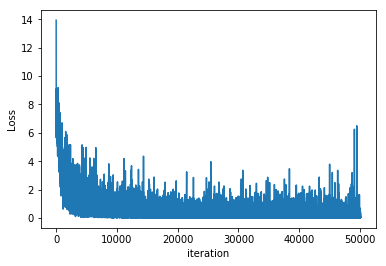

In [76]:
_ = plt.plot(loss_history)
_ = plt.ylabel('Loss')
_ = plt.xlabel('iteration')

### Plot of validation accuracy

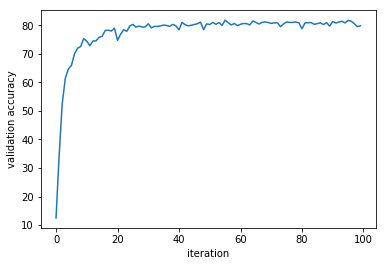

In [77]:
_ = plt.plot(cv_acc)
_ = plt.ylabel('validation accuracy')
_ = plt.xlabel('iteration')

## Show model structure in Tensorboard

In [43]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def


def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [72]:

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./model/SVHN_1544915580.meta')
    graph = tf.get_default_graph()
    show_graph(graph)

## Use best model to perform testing on test data

We load the above model here and test on the testing sample. The final accuracy is 82%.

In [63]:
##Load test data
import six.moves.cPickle as pickle
import os
import sys
import gzip

data_dir=os.getcwd()
output_file = 'testpkl.gz'
out_path = os.path.join(data_dir, output_file)
f_test = gzip.open(out_path, 'rb')
test_set = pickle.load(f_test)
f_test.close()

In [64]:
# Preprocess test data by substracting the mean image
x_test = test_set["images"]

x_test = x_test.astype(np.float32) - mean_image.astype(np.float32)
x_test= x_test.reshape([-1,54,54,3])

In [65]:
#Create labels and length list
label_test=[]
length_test=[]
for i in range(len(test_set["labels"])):
    label_test.append([int(x) for x in test_set["labels"][i]])
    length_test.append(len(label_test[-1]))

In [66]:
# Testing function
def Test(x_test,length_val,label_val,pre_trained_model):
# Input:  x_test: test image, dimension = (n, 54, 54, 3)
#         length_val: list of length for each test sample, dimension = (n, 1)
#         label_val: list of digits for each sample
# Output: 
#         valid_acc_test: prediction accuracy
    tf.reset_default_graph()

    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, shape=(None,54,54,3))
        length_labels = tf.placeholder(tf.int64, shape=(None,None,))
        digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))

    length_logits_test, digits_logits_test, loss_test = model(x, length_labels, digits_labels, 
                                                           is_training=False)

    length_predictions, digits_predictions = predict(length_logits_test, digits_logits_test)

    with tf.Session() as sess:

        new_saver = tf.train.Saver()
        new_saver.restore(sess, pre_trained_model)

        length_test, digit_test = sess.run([length_predictions, digits_predictions],feed_dict={x:x_test})
        pred_str_test, valid_acc_test = evaluate(length_test, digit_test, length_val, label_val)
        

    return valid_acc_test

In [70]:
# Run Testing session
# Due to resource issue, we are testing all samples by batches and calculate the final accuracy
#as the average of all test batches
num_batches = 100
num_iterates = x_test.shape[0]//num_batches
tot_acc = []
for i in range (num_iterates):
    x_test_new = x_test[i*num_batches:num_batches*(i+1)]
    length_test_new = length_test[i*num_batches:num_batches*(i+1)]
    label_test_new = label_test[i*num_batches:num_batches*(i+1)]
    acc = Test(x_test_new,length_test_new,label_test_new,pre_trained_model="./model/SVHN_1544915580")
    tot_acc.append(acc)
tot = sum(tot_acc)/len(tot_acc)

print( "Total Testing Accuracy : {}%".format(tot))


INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tenso

INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544915580
Total Testing Accuracy : 81.97692307692307%
